In [98]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import sklearn
import arrow
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification #generates a random classification problem
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter
from IPython.display import clear_output
from mlxtend.plotting import plot_decision_regions #plotting regions
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pprint as pp


from sklearn.datasets import make_classification #generates a random classification problem
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter
from sklearn import svm, ensemble, linear_model, neighbors, naive_bayes

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions #plotting regions
%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 


%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
%pylab inline

sns.set_style("white")





Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['arrow']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Reading Data Sources

In [64]:
path ="/Users/nayefalhaidari/Downloads/Geolife Trajectories 1.3/Data"
all_files = {}
folders  = os.listdir(path)
folders = [folder for folder in folders if (folder != ".DS_Store")and ("labels.txt" in os.listdir(path+"/"+folder)) ]
for folder in folders:
    all_files[folder]= {"data_files":[path+"/"+folder+'/Trajectory/'+x for x in os.listdir(path+"/"+folder+'/Trajectory')]
                        ,"labels_file":path+"/"+folder+"/labels.txt"}

Reading Data

In [66]:
all_data = pd.DataFrame()
counter =0
for user, files in all_files.items():
    counter +=1
    print( counter,end="\t")
    if counter  == 80:
        break
    for file in files["data_files"]:
#         print( counter)
        s_df = pd.read_csv(file,skiprows=[x for x in range (5)],header=0,names=["lat","lng","all_0","altitude"," Date - number of days","date","time"])
#         print (s_df)
        
        s_df["user"] = user
        all_data = pd.concat([all_data, s_df],ignore_index=True)   
#         counter +=1
    if counter%10 ==0:
        #clear_output()
        print("\n")

Reading Featers data

In [ ]:
label_files = [(x[0],x[1]['labels_file']) for x  in all_files.items()]
labels_data = pd.DataFrame()
counter =0
for user, file in label_files:
    counter +=1
    print( counter,end="\t")
    s_df = pd.read_csv(file,header=0,sep= "\t")
         print (s_df)
    s_df["user"] = user
    labels_data = pd.concat([labels_data, s_df],ignore_index=True)   
         counter +=1
    if counter%10 ==0:
        #clear_output()
        print("\n")

perse dates and pickle data

In [ ]:
labels_data["Start Time"] = pd.to_datetime(labels_data["Start Time"])
labels_data["End Time"] = pd.to_datetime(labels_data["End Time"])
all_data["timestamp"] = pd.to_datetime(all_data["date"]+" "+all_data["time"])
all_data.drop(columns=["all_0", ' Date - number of days', 'date','time'], inplace= True)
all_data.to_pickle("/Users/nayefalhaidari/Documents/Project 3/prject_data.pickle")
labels_data.to_pickle("/Users/nayefalhaidari/Documents/Project 3/prject_labels_data.pickle")

Reload pickked fiels

In [67]:
all_data = pd.read_pickle("/Users/nayefalhaidari/Documents/Project 3/prject_data.pickle")
labels_data = pd.read_pickle("/Users/nayefalhaidari/Documents/Project 3/prject_labels_data.pickle")

Prepare dataframes

In [71]:
all_data.columns = [col.replace("-","_").lower() for col in all_data.columns]
labels_data.columns = [col.replace(" ","_").lower() for col in labels_data.columns]


Join the data using sql it's easier and less expensive 

In [18]:
import sqlite3
conn = sqlite3.connect(':memory:')
#write the tables
all_data.to_sql('all_data', conn, index=False)
labels_data.to_sql('labels_data', conn, index=False)


qry = '''
    select  
        *
    from
        all_data left join labels_data on
         all_data.user = labels_data.user and timestamp between start_time and end_time
    '''
df = pd.read_sql_query(qry, conn)


perse the timestamp 

In [ ]:
df.timestamp = pd.to_datetime(df.timestamp)

In [76]:
#df.to_pickle("/Users/nayefalhaidari/Documents/Project 3/prject_3_labeled_data.pickle")
proj_init_df = pd.read_pickle("/Users/nayefalhaidari/Documents/Project 3/prject_3_labeled_data.pickle")

Preapare the data

In [77]:
proj_init_df = proj_init_df.iloc[:,:-1]
proj_init_df.drop(index = proj_init_df[proj_init_df["start_time"].isna()].index, inplace=True)
proj_init_df = proj_init_df[proj_init_df["lat"]<=90]
proj_init_df.loc[proj_init_df["altitude"]==-777,"altitude"] = np.nan
proj_init_df["timestamp"] = pd.to_datetime(proj_init_df["timestamp"])
proj_init_df["end_time"] = pd.to_datetime(proj_init_df["end_time"])
proj_init_df["start_time"] = pd.to_datetime(proj_init_df["start_time"])
proj_init_df.sort_values(by = ["user","timestamp"],ascending=[1, 1],inplace=True)

In [78]:
def calculate_m(df, group):
    """that function take a data frame and caculate all the featuers based on the gps signals"""
    
    df["time_diff"] = df.groupby(group)["timestamp"].diff()
    df["lat_diff"]  = df.groupby([group])["lat"].diff()
    df["lng_diff"]  = df.groupby([group])["lng"].diff()
    df["alt_diff"]  = df.groupby([group])["altitude"].diff()
    df["distance"]  = (df["lat_diff"]**2 + df["lng_diff"]**2)**0.5 *100000/1.1132
    df["speed(m/s)"]= df["distance"]/df.time_diff.astype("timedelta64[s]")
    df["prev_lat"]  = np.where(df[group] == df[group].shift(),df["lat"].shift(),np.nan)
    df["prev_lng"]  = np.where(df[group] == df[group].shift(),df["lng"].shift(),np.nan)
    df["prev_2_lng"]  = np.where(df[group] == df[group].shift(2),df["lng"].shift(2),np.nan)
    df["prev_2_lat"]  = np.where(df[group] == df[group].shift(2),df["lat"].shift(2),np.nan)
    df["a_c_distance"]  = ((df["lat"]-df["prev_2_lat"])**2 + (df["lng"]-df["prev_2_lng"])**2 )**0.5 *100000/1.1132
    df["a_b_c_distance"] =   np.where(df[group] == df[group].shift(),df["distance"]+df["distance"].shift(),np.nan)
    df["speed_diff"] =      df.groupby([group])["speed(m/s)"].diff()
    df["accelerattion"] = df["speed_diff"]/df["time_diff"].astype("timedelta64[s]")
def reset_col(df):
    """that function remove all the features added to the data frame"""
    
    df = df[['altitude', 'lat', 'lng', 'timestamp', 'user',
             'start_time','transportation_mode']+["group" if "group" in df.columns else 'end_time']]



In [79]:
calculate_m(proj_init_df,"user")
proj_init_df = proj_init_df[proj_init_df["time_diff"]>dt.timedelta(seconds = 0 )]
reset_col(proj_init_df)
calculate_m(proj_init_df,"user")

/anaconda3/lib/python3.7/site-packages/pandas/core/algorithms.py:1819: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


In [80]:
counter = 1 
def categrizer(row,):
    global counter
    if (row["time_diff"] == pd.NaT):
        return np.nan
        counter +=1
    elif (row["time_diff"]>dt.timedelta(minutes = 2)):
        counter +=1
        return np.nan
    return counter
    
proj_init_df["group"]=proj_init_df.apply(categrizer,axis=1)

In [81]:
proj_init_df.drop(
    index = proj_init_df[proj_init_df["a_b_c_distance"]>3*proj_init_df["a_c_distance"]].index,inplace=True)

In [82]:
reset_col(proj_init_df)
calculate_m(proj_init_df,"group")


In [83]:
q75 = proj_init_df["distance"].quantile(0.75)
q25 = proj_init_df["distance"].quantile(0.25)
iqr = q75-q25
ul = 1.5*iqr + q75
ll = max(0,q25 - 1.5*iqr)
proj_init_df = (proj_init_df[(proj_init_df["distance"]>ll) &( proj_init_df["distance"]<ul)])
reset_col(proj_init_df)
calculate_m(proj_init_df,"group")

In [32]:
#proj_init_df.to_pickle("/Users/nayefalhaidari/Documents/Project 3/init_data.pickle")

In [33]:
#proj_init_df = pd.read_pickle("/Users/nayefalhaidari/Documents/Project 3/init_data.pickle")

In [84]:
import math
proj_init_df["direction"] = proj_init_df.apply(lambda x: math.atan2(x['lat_diff'], x['lng_diff']), axis=1).apply(math.degrees)
proj_init_df["direction_change"] = proj_init_df.groupby(["group"])["direction"].diff()
proj_init_df["direction_change"] =  proj_init_df["direction_change"].apply(lambda x: abs(x) if abs(x) <180 else 360-abs(x))

In [89]:
#proj_init_df.to_pickle("/Users/nayefalhaidari/Documents/Project 3/prject_3_labeled_data_v1.3.pickle")
#proj_init_df = pd.read_pickle("/Users/nayefalhaidari/Documents/Project 3/prject_3_labeled_data_v1.3.pickle")

In [91]:
def smoothing(df, columns,start = 0, end = 5 ,alpha = 0.0):
    for col in columns:
        for i in range(start,end):
            df[f"{col}{'_smoothed_'}{str(i+1)}"]= (
                np.where((df["group"]==df["group"].shift(i+1)),
             df[f"{col}{'_smoothed_'*(int(bool(i)))}{str(i) if i >0 else ''}"]*alpha 
                          + df[col].shift(i+1)*(1-alpha)               
             ,np.nan)
)

In [92]:
daf = proj_init_df.copy()
smoothing(daf, ["speed(m/s)","direction_change",'accelerattion' ],end = 5)

In [95]:
model1 = daf.copy()
model1.drop(columns = ['altitude', 'lat', 'lng', 'timestamp', 'user', 'start_time', 'end_time','time_diff','lat_diff', 'lng_diff', 'alt_diff',
                      'distance','a_c_distance', 'a_b_c_distance', 'group','speed_diff', 'direction','prev_lat', 'prev_lng',"prev_2_lng","prev_2_lat"],inplace=True)
model1.dropna(inplace = True)
modes = {"walk":"walk", "bus":"bus","bike":"bike","train":"train","car":"car","subway":"drop","taxi":"car",
        "airplane":"drop","boat":"drop","run":"walk","motorcycle":"drop"}
model1["transportation_mode2"] = model1.apply(lambda x : modes[x["transportation_mode"]],axis=1)
model1 = model1[model1["transportation_mode2"]!="drop"]
model1.drop(columns="transportation_mode",inplace=True)
model1.drop(index = model1[model1["speed(m/s)"]<0].index,inplace=True)

In [ ]:
# model1.to_pickle("model1_data.pickle")
model1 = pd.read_pickle("model1_data.pickle")

In [36]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (9,5), fontsize=18):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

,speed(m/s),direction_change,accelerattion,speed(m/s)_smoothed_1,speed(m/s)_smoothed_2,speed(m/s)_smoothed_3,speed(m/s)_smoothed_4,speed(m/s)_smoothed_5,direction_change_smoothed_1,direction_change_smoothed_2,direction_change_smoothed_3,direction_change_smoothed_4,direction_change_smoothed_5,accelerattion_smoothed_1,accelerattion_smoothed_2,accelerattion_smoothed_3,accelerattion_smoothed_4,accelerattion_smoothed_5,transportation_mode2
7,0.161489,1.549065e+02,5.517579e-04,0.102395,9.685616,16.329177,12.530314,18.514142,151.520531,53.063510,26.140566,43.303456,28.296620,-0.026956,-0.004472,0.001644,-0.000868,0.008461,train
8,0.070057,1.101539e+02,-2.575537e-04,0.152345,0.101481,9.685524,16.329168,12.530313,164.400425,152.469928,53.158450,26.150060,43.304406,0.000471,-0.026965,-0.004473,0.001644,-0.000868,train
9,0.044201,1.724286e+02,-6.913413e-05,0.067471,0.152087,0.101455,9.685522,16.329168,242.104385,163.626250,152.392511,53.150708,26.149286,-0.000239,0.000473,-0.026964,-0.004473,0.001644,train
10,0.026629,1.732673e+02,-9.927544e-05,0.042444,0.067296,0.152069,0.101453,9.685521,173.859027,242.247426,163.640554,152.393941,53.150851,-0.000072,-0.000239,0.000473,-0.026964,-0.004473,train
11,20.322628,1.783701e+01,7.878881e-03,2.056229,0.245404,0.087592,0.154099,0.101656,169.843146,172.170070,242.078530,163.623665,152.392252,0.000699,0.000008,-0.000231,0.000473,-0.026964,train
12,0.293614,2.014799e+01,-3.394748e-01,18.319726,1.855939,0.225375,0.085589,0.153899,18.068112,169.866256,172.172381,242.078761,163.623688,-0.026856,-0.002775,-0.000340,-0.000266,0.000470,train
13,10.002084,2.831828e+01,2.048200e-02,1.264461,18.416811,1.865647,0.226346,0.085686,20.965022,18.149814,169.874426,172.173198,242.078843,-0.303479,-0.023257,-0.002415,-0.000304,-0.000262,train
14,5.279364,9.043983e+00,-6.125447e-03,9.529812,1.217233,18.412088,1.865175,0.226298,26.390854,20.772279,18.130540,169.872499,172.173005,0.017821,-0.303745,-0.023284,-0.002418,-0.000304,train
22,0.206131,7.563190e+01,1.147098e-03,0.145221,14.843608,1.883447,0.348670,0.215746,20.906809,76.753734,196.753227,237.076687,90.316044,-0.249114,-0.021047,0.001942,-0.000154,-0.004343,train
23,0.054648,3.899959e+00,-1.283757e-03,0.190983,0.143706,14.843457,1.883432,0.348669,68.458705,20.189489,76.682002,196.746054,237.075970,0.000904,-0.249138,-0.021049,0.001942,-0.000154,train


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The score for logistic regression is
Training:  51.22%
Test set:  51.21%
--------------------


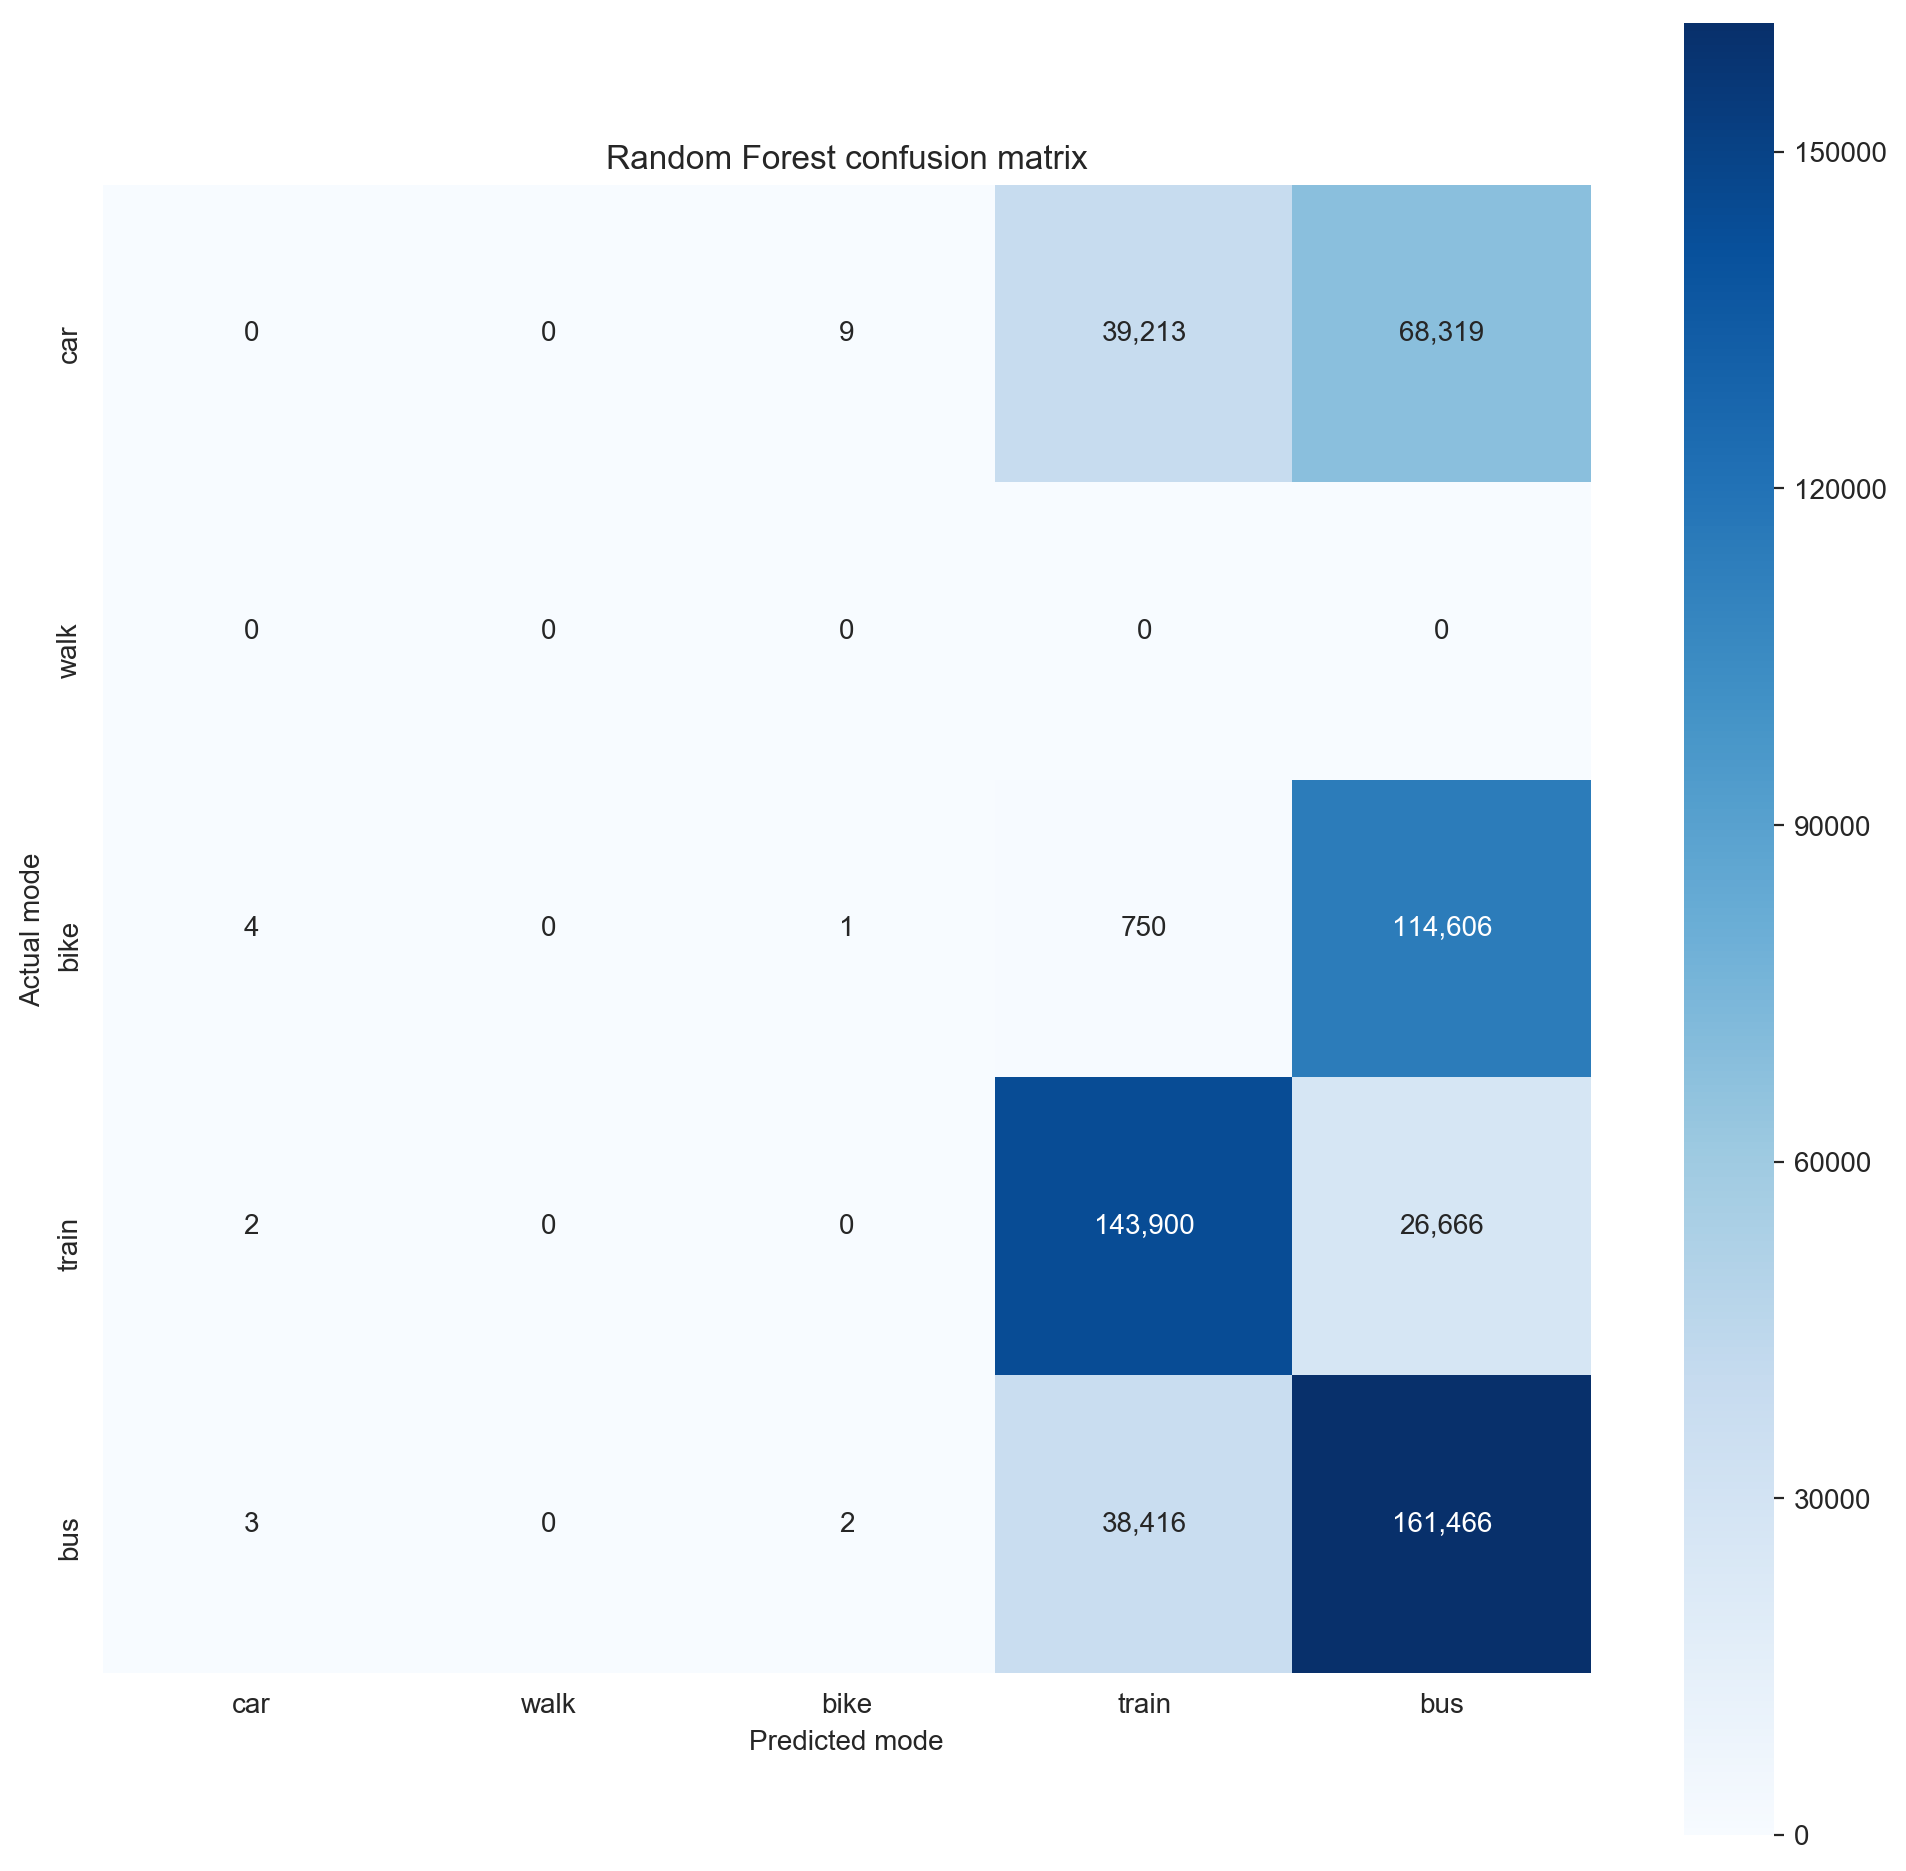

In [175]:
X = model1.iloc[:,:-1]
y = model1.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)
logit1 = LogisticRegression(n_jobs=16, C = 0.95,solver= "newton-cg")
logit1.fit(X_train, y_train)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*logit1.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit1.score(X_test, y_test)),end = "\n"+"-"*20+"\n")
pickle.dump(logit1,  open("Logistic Rigrission_1","wb"))
plt.figure(figsize=(12,12),dpi=100)

rforest_confusion = confusion_matrix(y_test, logit1.predict(X_test),labels=["car", "walk" , "bike","train","bus"])
sns.heatmap(rforest_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt = ",d",
           xticklabels=["car", "walk" , "bike","train","bus"],
            yticklabels=["car", "walk" , "bike","train","bus"],)

plt.xlabel('Predicted mode')
plt.ylabel('Actual mode')
plt.title('Random Forest confusion matrix')
plt.savefig("Logist_regrission1.eps",format="eps")


In [170]:
model1["transportation_mode2"] = np.where(model1["transportation_mode2"] =="feet", "walk", model1["transportation_mode2"])
speed_df = model1.loc[:,[col for col in model1.columns if col[:4] == "spee"]]
dire_df = model1.loc[:,[col for col in model1.columns if col[:4] == "dire"]]
acce_df = model1.loc[:,[col for col in model1.columns if col[:4] == "acce"]]
b = model1.loc[:,'transportation_mode2']

a = speed_df.values
a.sort(axis=1)
a = a[:,::-1]
speed_df = pd.DataFrame(a, speed_df.index, speed_df.columns)

a = dire_df.values
a.sort(axis=1)
a = a[:,::-1]
dire_df = pd.DataFrame(a, dire_df.index, dire_df.columns)

a = acce_df.values
a.sort(axis=1)
a = a[:,::-1]
acce_df = pd.DataFrame(a, acce_df.index, acce_df.columns)

model1_s = pd.concat([speed_df,dire_df,acce_df,b],axis=1)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The score for logistic regression is
Training:  55.84%
Test set:  55.82%
--------------------


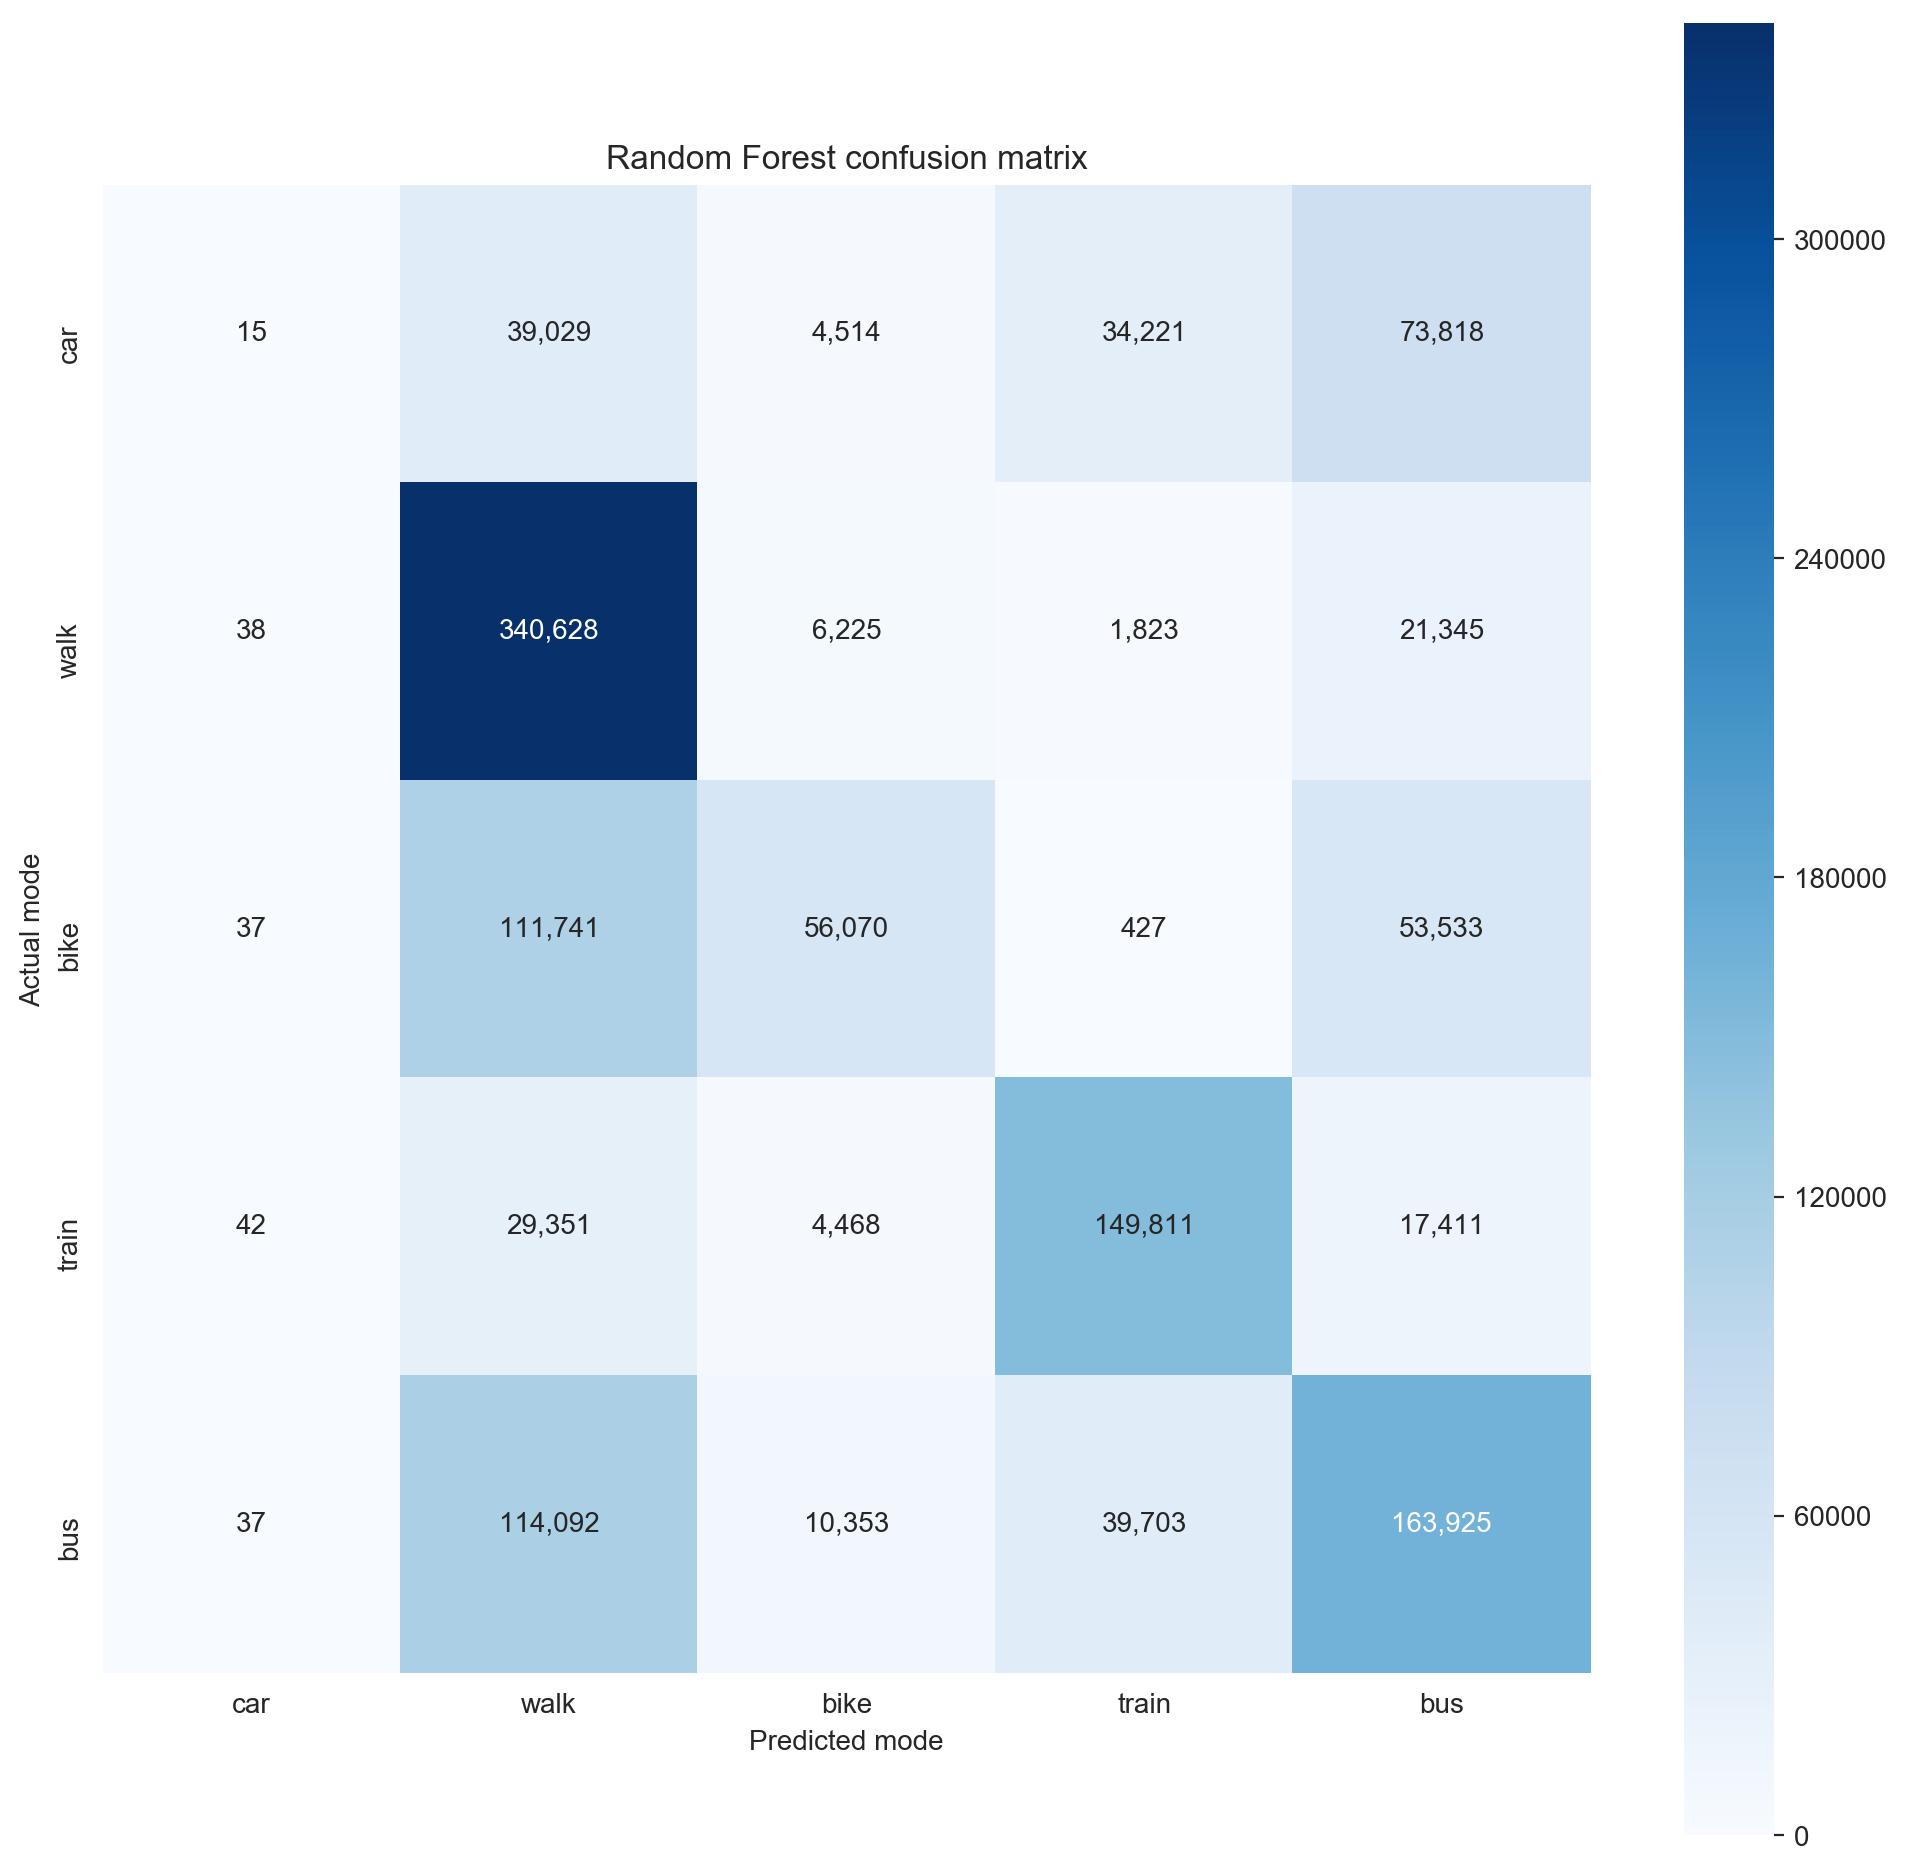

In [171]:
X = model1_s.iloc[:,:-1]
y = model1_s.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)
logit3 = LogisticRegression(n_jobs=16,C = 0.95,solver = "newton-cg")
logit3.fit(X_train, y_train)
print("The score for logistic regression is")
#score returns mean accuracy
pickle.dump(logit3,  open("Logistic Rigrission_3","wb"))
print("Training: {:6.2f}%".format(100*logit3.score(X_train, y_train)))



print("Test set: {:6.2f}%".format(100*logit3.score(X_test, y_test)),end = "\n"+"-"*20+"\n")

plt.figure(figsize=(12,12),dpi=100)
rforest_confusion = confusion_matrix(y_test, logit3.predict(X_test),labels=["car", "walk" , "bike","train","bus"])
sns.heatmap(rforest_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt = ",d",
           xticklabels=["car", "walk" , "bike","train","bus"],
            yticklabels=["car", "walk" , "bike","train","bus"],)

plt.xlabel('Predicted mode')
plt.ylabel('Actual mode')
plt.title('Random Forest confusion matrix')
plt.savefig("Logist_regrission3.eps",format="eps")

In [193]:
smoothing(daf, ["speed(m/s)","direction_change",'accelerattion' ],start = 5,end  = 10)
model2 = daf.copy()
model2.dropna(inplace = True)
model2.drop(columns = ['altitude', 'lat', 'lng', 'timestamp', 'user', 'start_time', 'end_time',
                       'time_diff','lat_diff', 'lng_diff', 'alt_diff','distance',
                       'a_c_distance', 'a_b_c_distance', 'group','speed_diff', 'direction',
                       'prev_lat', 'prev_lng',"prev_2_lng","prev_2_lat"],inplace=True)

modes = {"walk":"walk", "bus":"bus","bike":"bike","train":"train","car":"car","subway":"drop","taxi":"car",
        "airplane":"drop","boat":"drop","run":"walk","motorcycle":"drop"}

model2["transportation_mode2"] = model2.apply(lambda x : modes[x["transportation_mode"]],axis=1)
model2 = model2[model2["transportation_mode2"]!="drop"]
model2.drop(columns="transportation_mode",inplace=True)
model2.drop(index = model1[model1["speed(m/s)"]<0].index,inplace=True)
model2.dropna(inplace =True)

Index(['speed(m/s)', 'accelerattion', 'direction_change',
       'speed(m/s)_smoothed_1', 'speed(m/s)_smoothed_2',
       'speed(m/s)_smoothed_3', 'speed(m/s)_smoothed_4',
       'speed(m/s)_smoothed_5', 'direction_change_smoothed_1',
       'direction_change_smoothed_2', 'direction_change_smoothed_3',
       'direction_change_smoothed_4', 'direction_change_smoothed_5',
       'accelerattion_smoothed_1', 'accelerattion_smoothed_2',
       'accelerattion_smoothed_3', 'accelerattion_smoothed_4',
       'accelerattion_smoothed_5', 'speed(m/s)_smoothed_6',
       'speed(m/s)_smoothed_7', 'speed(m/s)_smoothed_8',
       'speed(m/s)_smoothed_9', 'speed(m/s)_smoothed_10',
       'direction_change_smoothed_6', 'direction_change_smoothed_7',
       'direction_change_smoothed_8', 'direction_change_smoothed_9',
       'direction_change_smoothed_10', 'accelerattion_smoothed_6',
       'accelerattion_smoothed_7', 'accelerattion_smoothed_8',
       'accelerattion_smoothed_9', 'accelerattion_smoothed

In [140]:
# model2.to_pickle("model2_data.pickle")
# model2 = pd.read_pickle("model2_data.pickle")

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The score for logistic regression is
Training:  54.01%
Test set:  53.99%


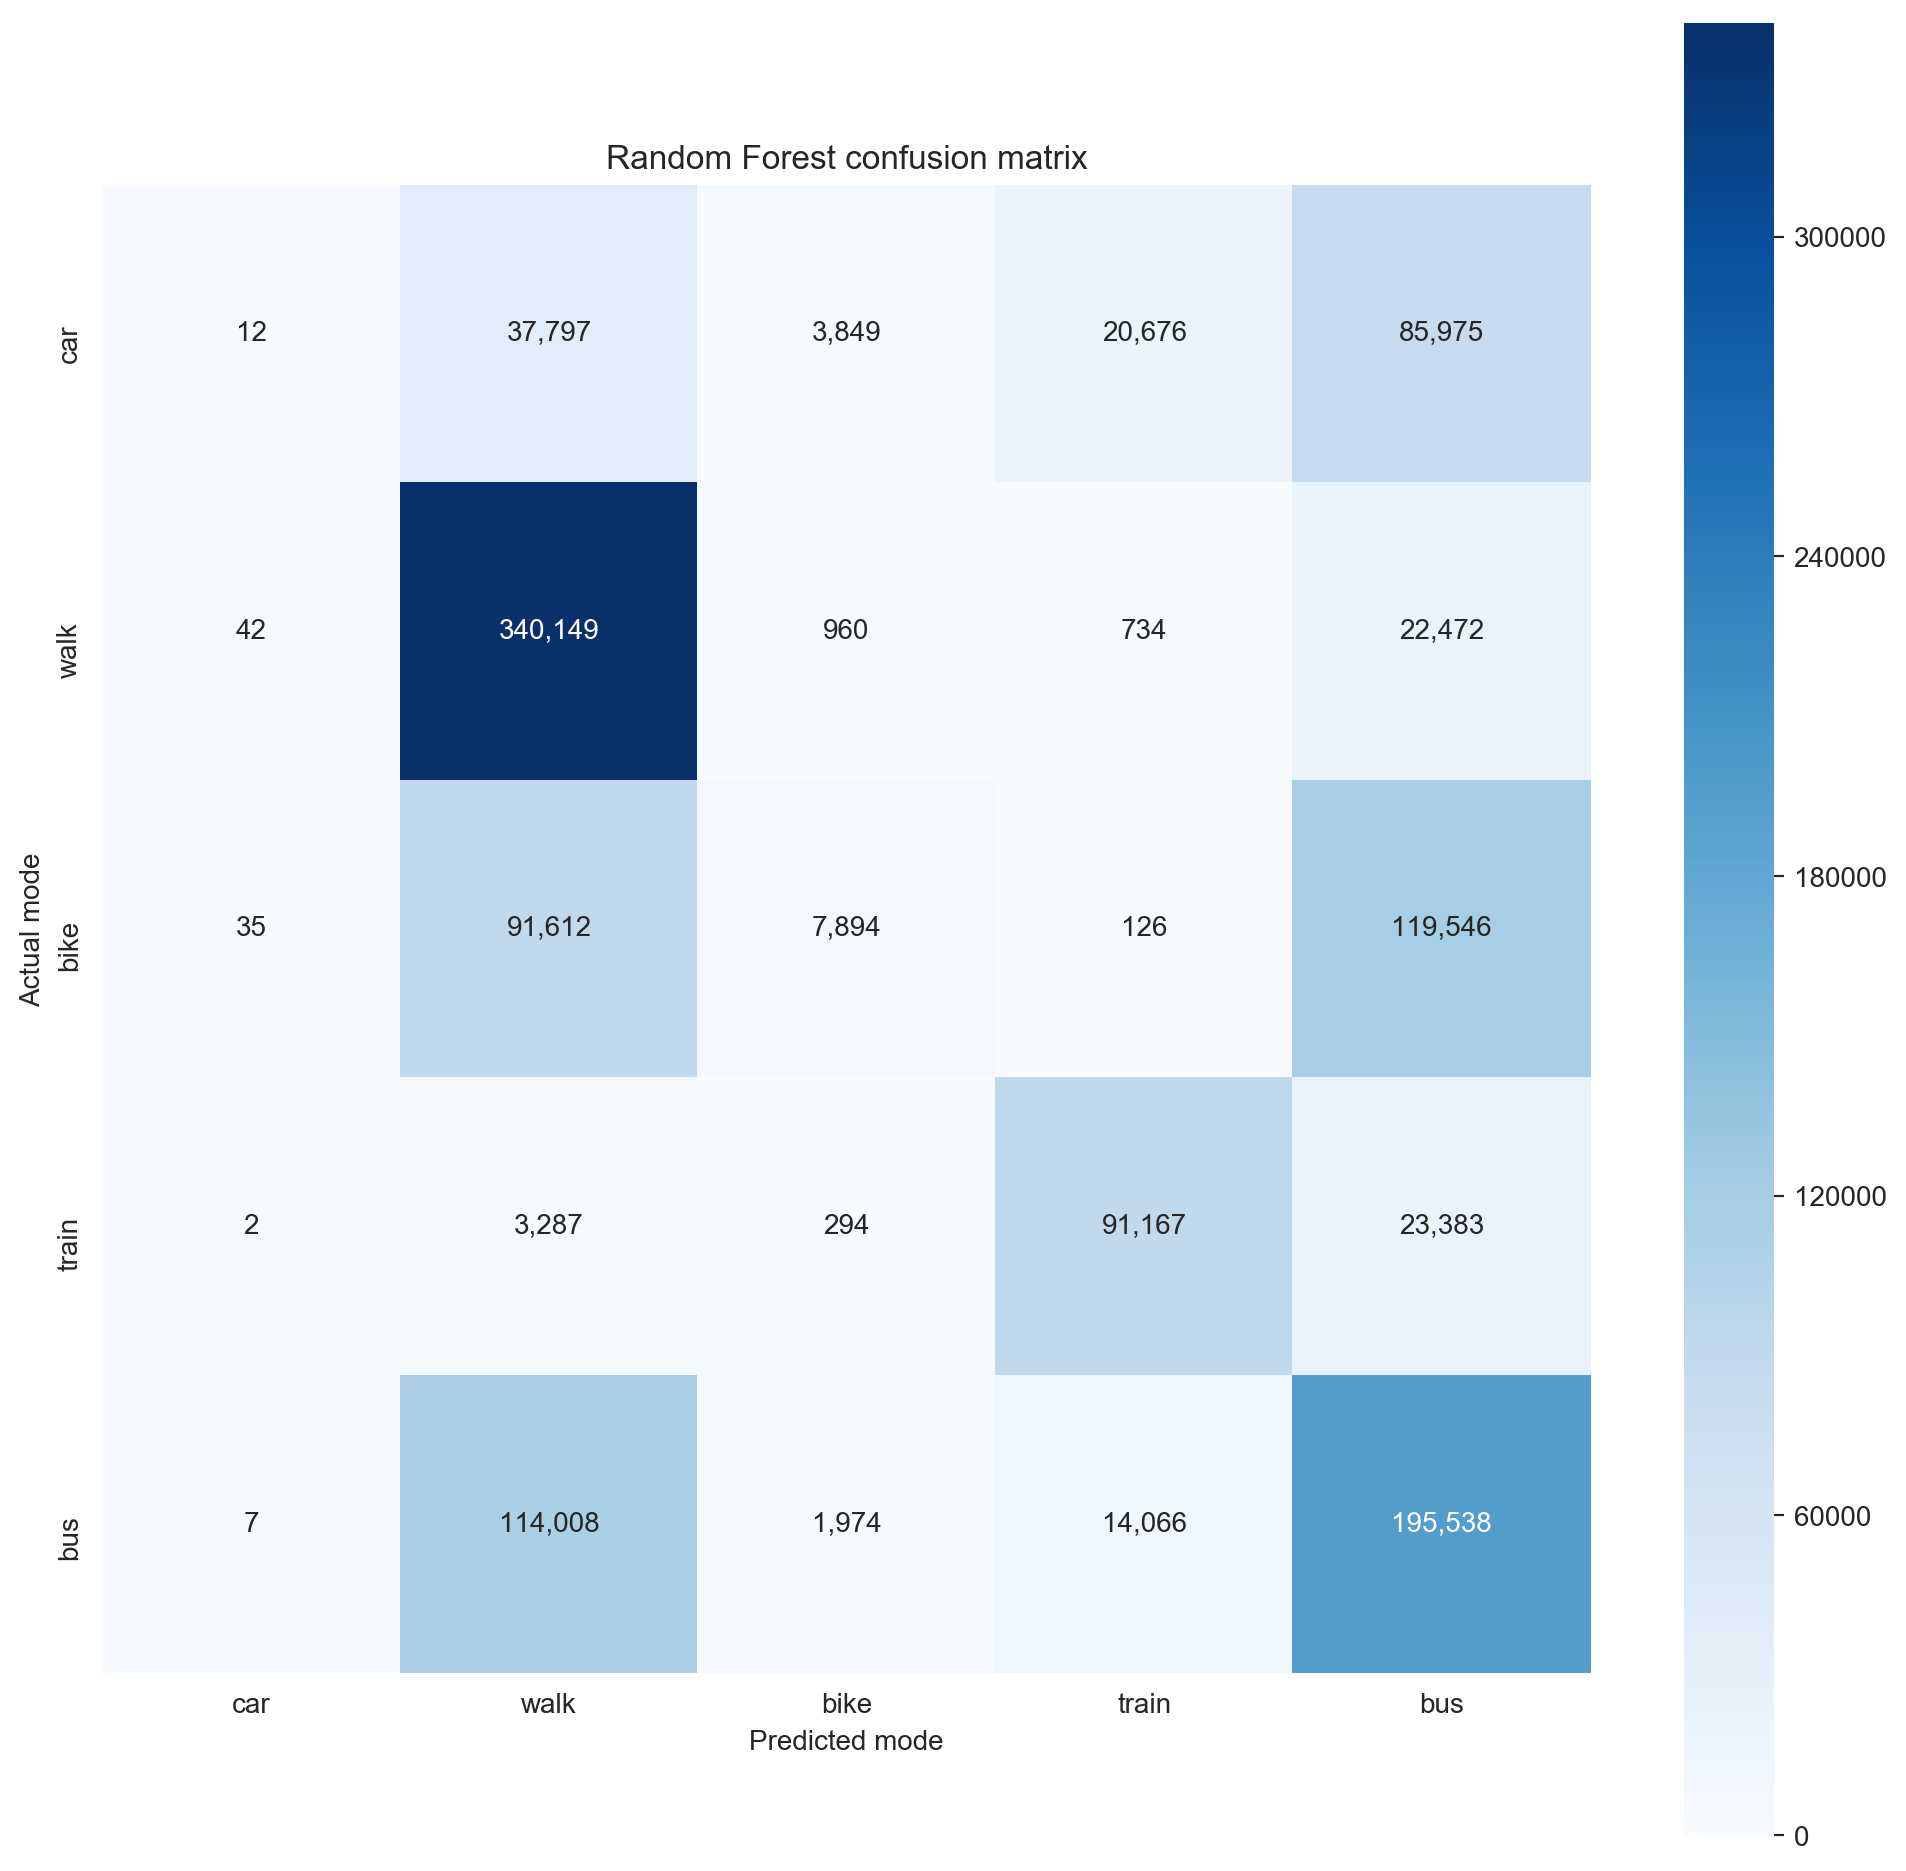

In [142]:
X = model2.iloc[:,:-1]
y = model2.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)
logit6 = LogisticRegression(n_jobs=-1, C = 0.95,solver = "newton-cg")
logit6.fit(X_train, y_train)
pickle.dump(logit6,  open("Logistic Rigrission_6","wb"))

print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*logit6.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit6.score(X_test, y_test)))

plt.figure(figsize=(12,12),dpi=100)
rforest_confusion = confusion_matrix(y_test, logit6.predict(X_test),labels=["car", "walk" , "bike","train","bus"])
sns.heatmap(rforest_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt = ",d",
           xticklabels=["car", "walk" , "bike","train","bus"],
            yticklabels=["car", "walk" , "bike","train","bus"],)

plt.xlabel('Predicted mode')
plt.ylabel('Actual mode')
plt.title('Random Forest confusion matrix')
plt.savefig("Logist_regrission6.eps",format="eps")

In [183]:
speed_df = model2.loc[:,[col for col in model1.columns if col[:4] == "spee"]]
dire_df = model2.loc[:,[col for col in model1.columns if col[:4] == "dire"]]
acce_df = model2.loc[:,[col for col in model1.columns if col[:4] == "acce"]]
b = model2.loc[:,'transportation_mode2']

a = speed_df.values
a.sort(axis=1)
a = a[:,::-1]
speed_df = pd.DataFrame(a, speed_df.index, speed_df.columns)

a = dire_df.values
a.sort(axis=1)
a = a[:,::-1]
dire_df = pd.DataFrame(a, dire_df.index, dire_df.columns)

a = acce_df.values
a.sort(axis=1)
a = a[:,::-1]
acce_df = pd.DataFrame(a, acce_df.index, acce_df.columns)

model2 = pd.concat([speed_df,dire_df,acce_df,b],axis=1)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The score for logistic regression is
Training:  57.93%
Test set:  57.93%


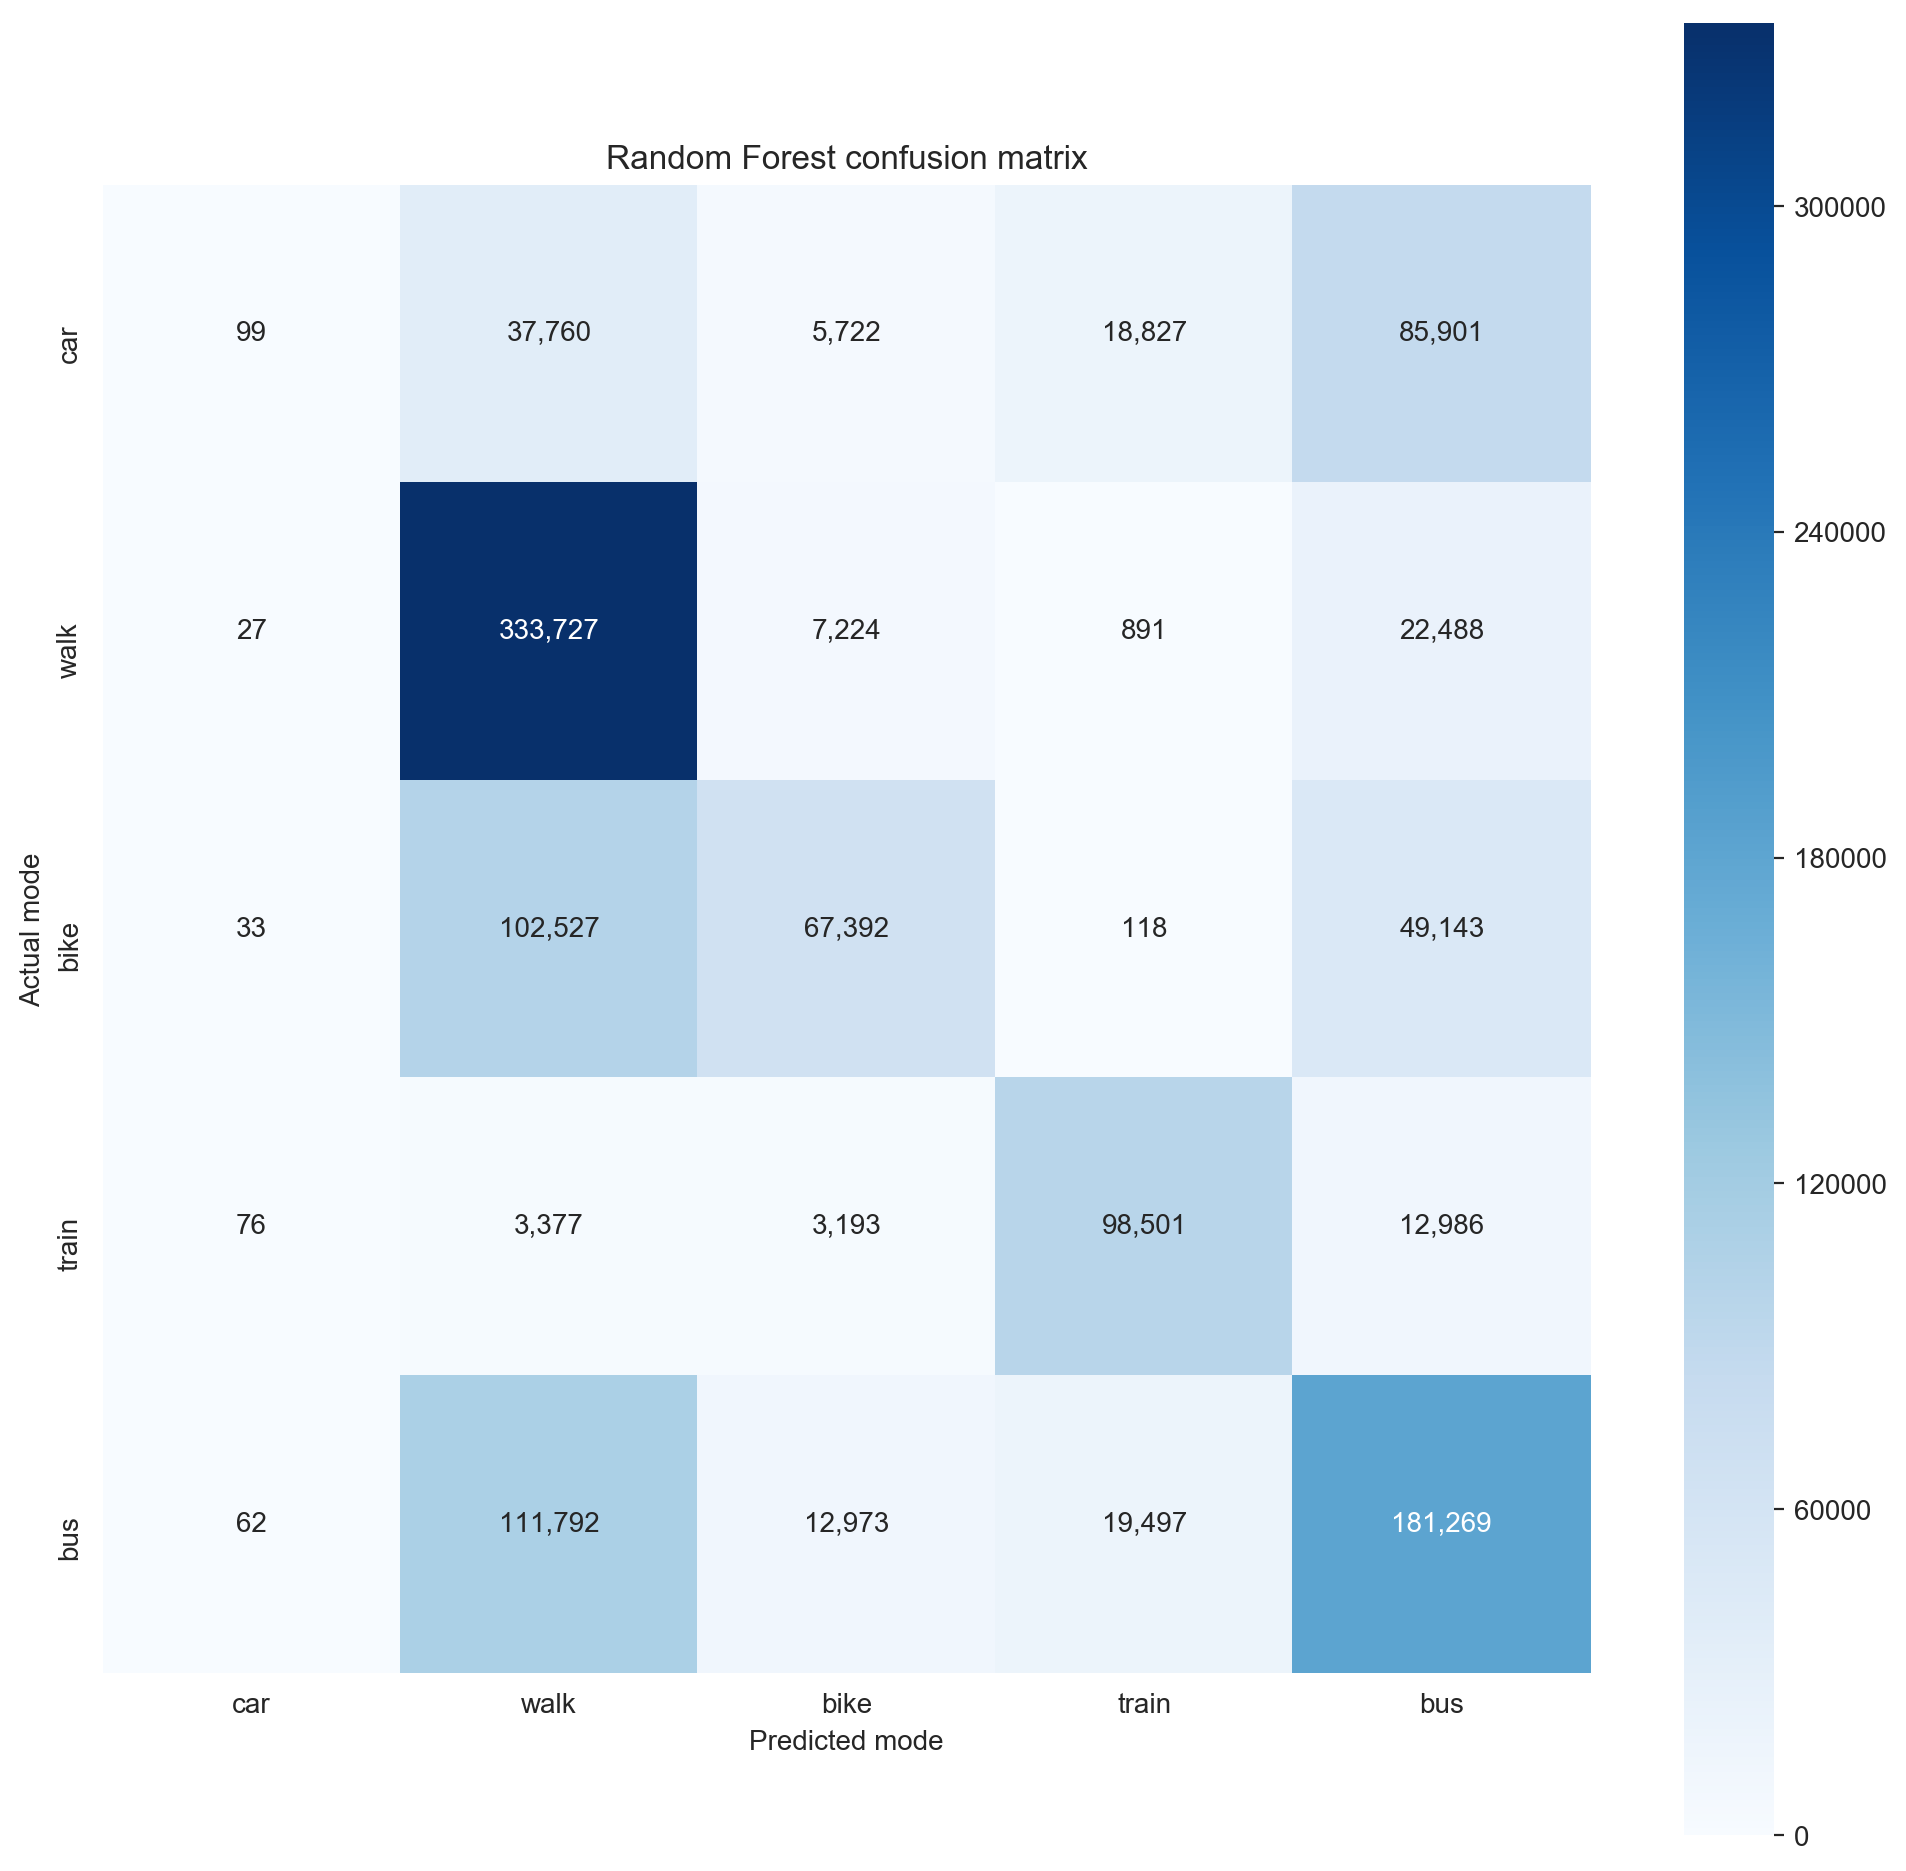

In [145]:
X = model2.iloc[:,:-1]
y = model2.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)
logit7 = LogisticRegression(n_jobs=-1, C = 0.95,solver = "newton-cg")
logit7.fit(X_train, y_train)
pickle.dump(logit7,  open("Logistic Rigrission_7","wb"))
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*logit7.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit7.score(X_test, y_test)))

plt.figure(figsize=(12,12),dpi=100)
rforest_confusion = confusion_matrix(y_test, logit7.predict(X_test),labels=["car", "walk" , "bike","train","bus"])
sns.heatmap(rforest_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt = ",d",
           xticklabels=["car", "walk" , "bike","train","bus"],
            yticklabels=["car", "walk" , "bike","train","bus"],)

plt.xlabel('Predicted mode')
plt.ylabel('Actual mode')
plt.title('Random Forest confusion matrix')
plt.savefig("Logist_regrission7.eps",format="eps")

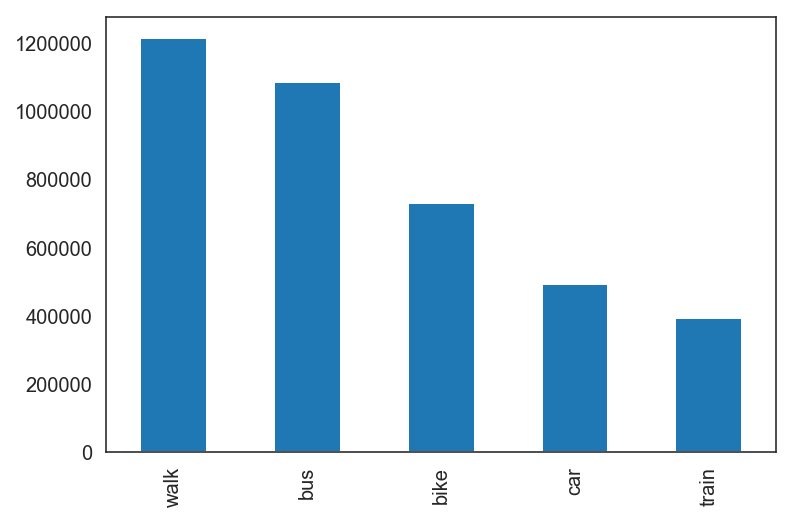

In [184]:
model2.transportation_mode2.value_counts().plot(kind = "bar")

In [197]:
X = model2.iloc[:,:-1]
y = model2.iloc[:,-1]
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X,y)

array([ 8.47465067e-01, -4.00508702e-01,  1.74894593e+00,  1.24797377e+00,
        3.20289193e+00,  9.37864400e-01,  2.69493353e+00,  1.65640396e+00,
        5.25054609e+01,  5.54977942e+00,  1.66992442e+01,  4.93987054e+01,
        2.55109511e+00, -1.95491816e+00,  1.13251377e+00, -8.78534562e-01,
        1.03852956e+00, -3.13746251e-01,  1.97015021e+00,  8.03473941e-01,
        1.34746676e+00,  2.53484568e+00,  1.33412931e-01,  2.02825591e+01,
        2.65650512e+01,  2.97448813e+01,  2.26198649e+01,  1.46763932e+01,
        1.16667627e+00, -5.43992821e-01, -1.18737892e+00,  1.20071638e+00,
       -4.74107516e-02])

<BarContainer object of 5 artists>

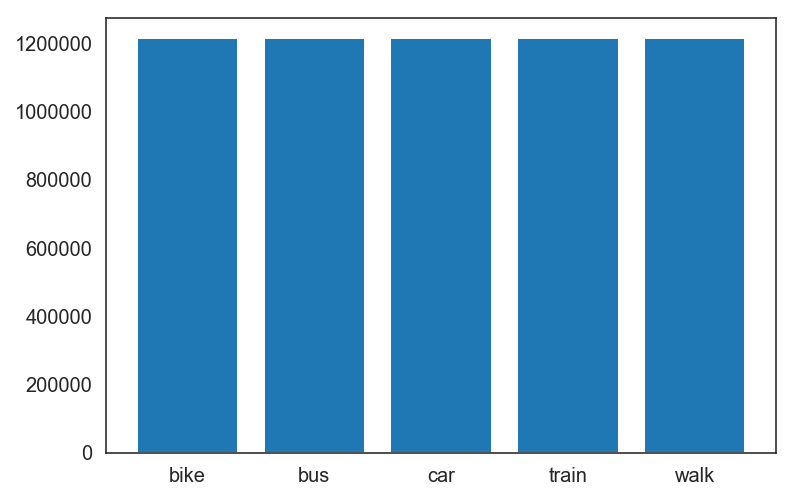

In [148]:
v,v_c =  np.unique(y_resampled, return_counts=True)
plt.bar([i[0] for i in zip(v,v_c)],[i[1] for i in zip(v,v_c)])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The score for logistic regression is
Training:  56.59%
Test set:  56.65%


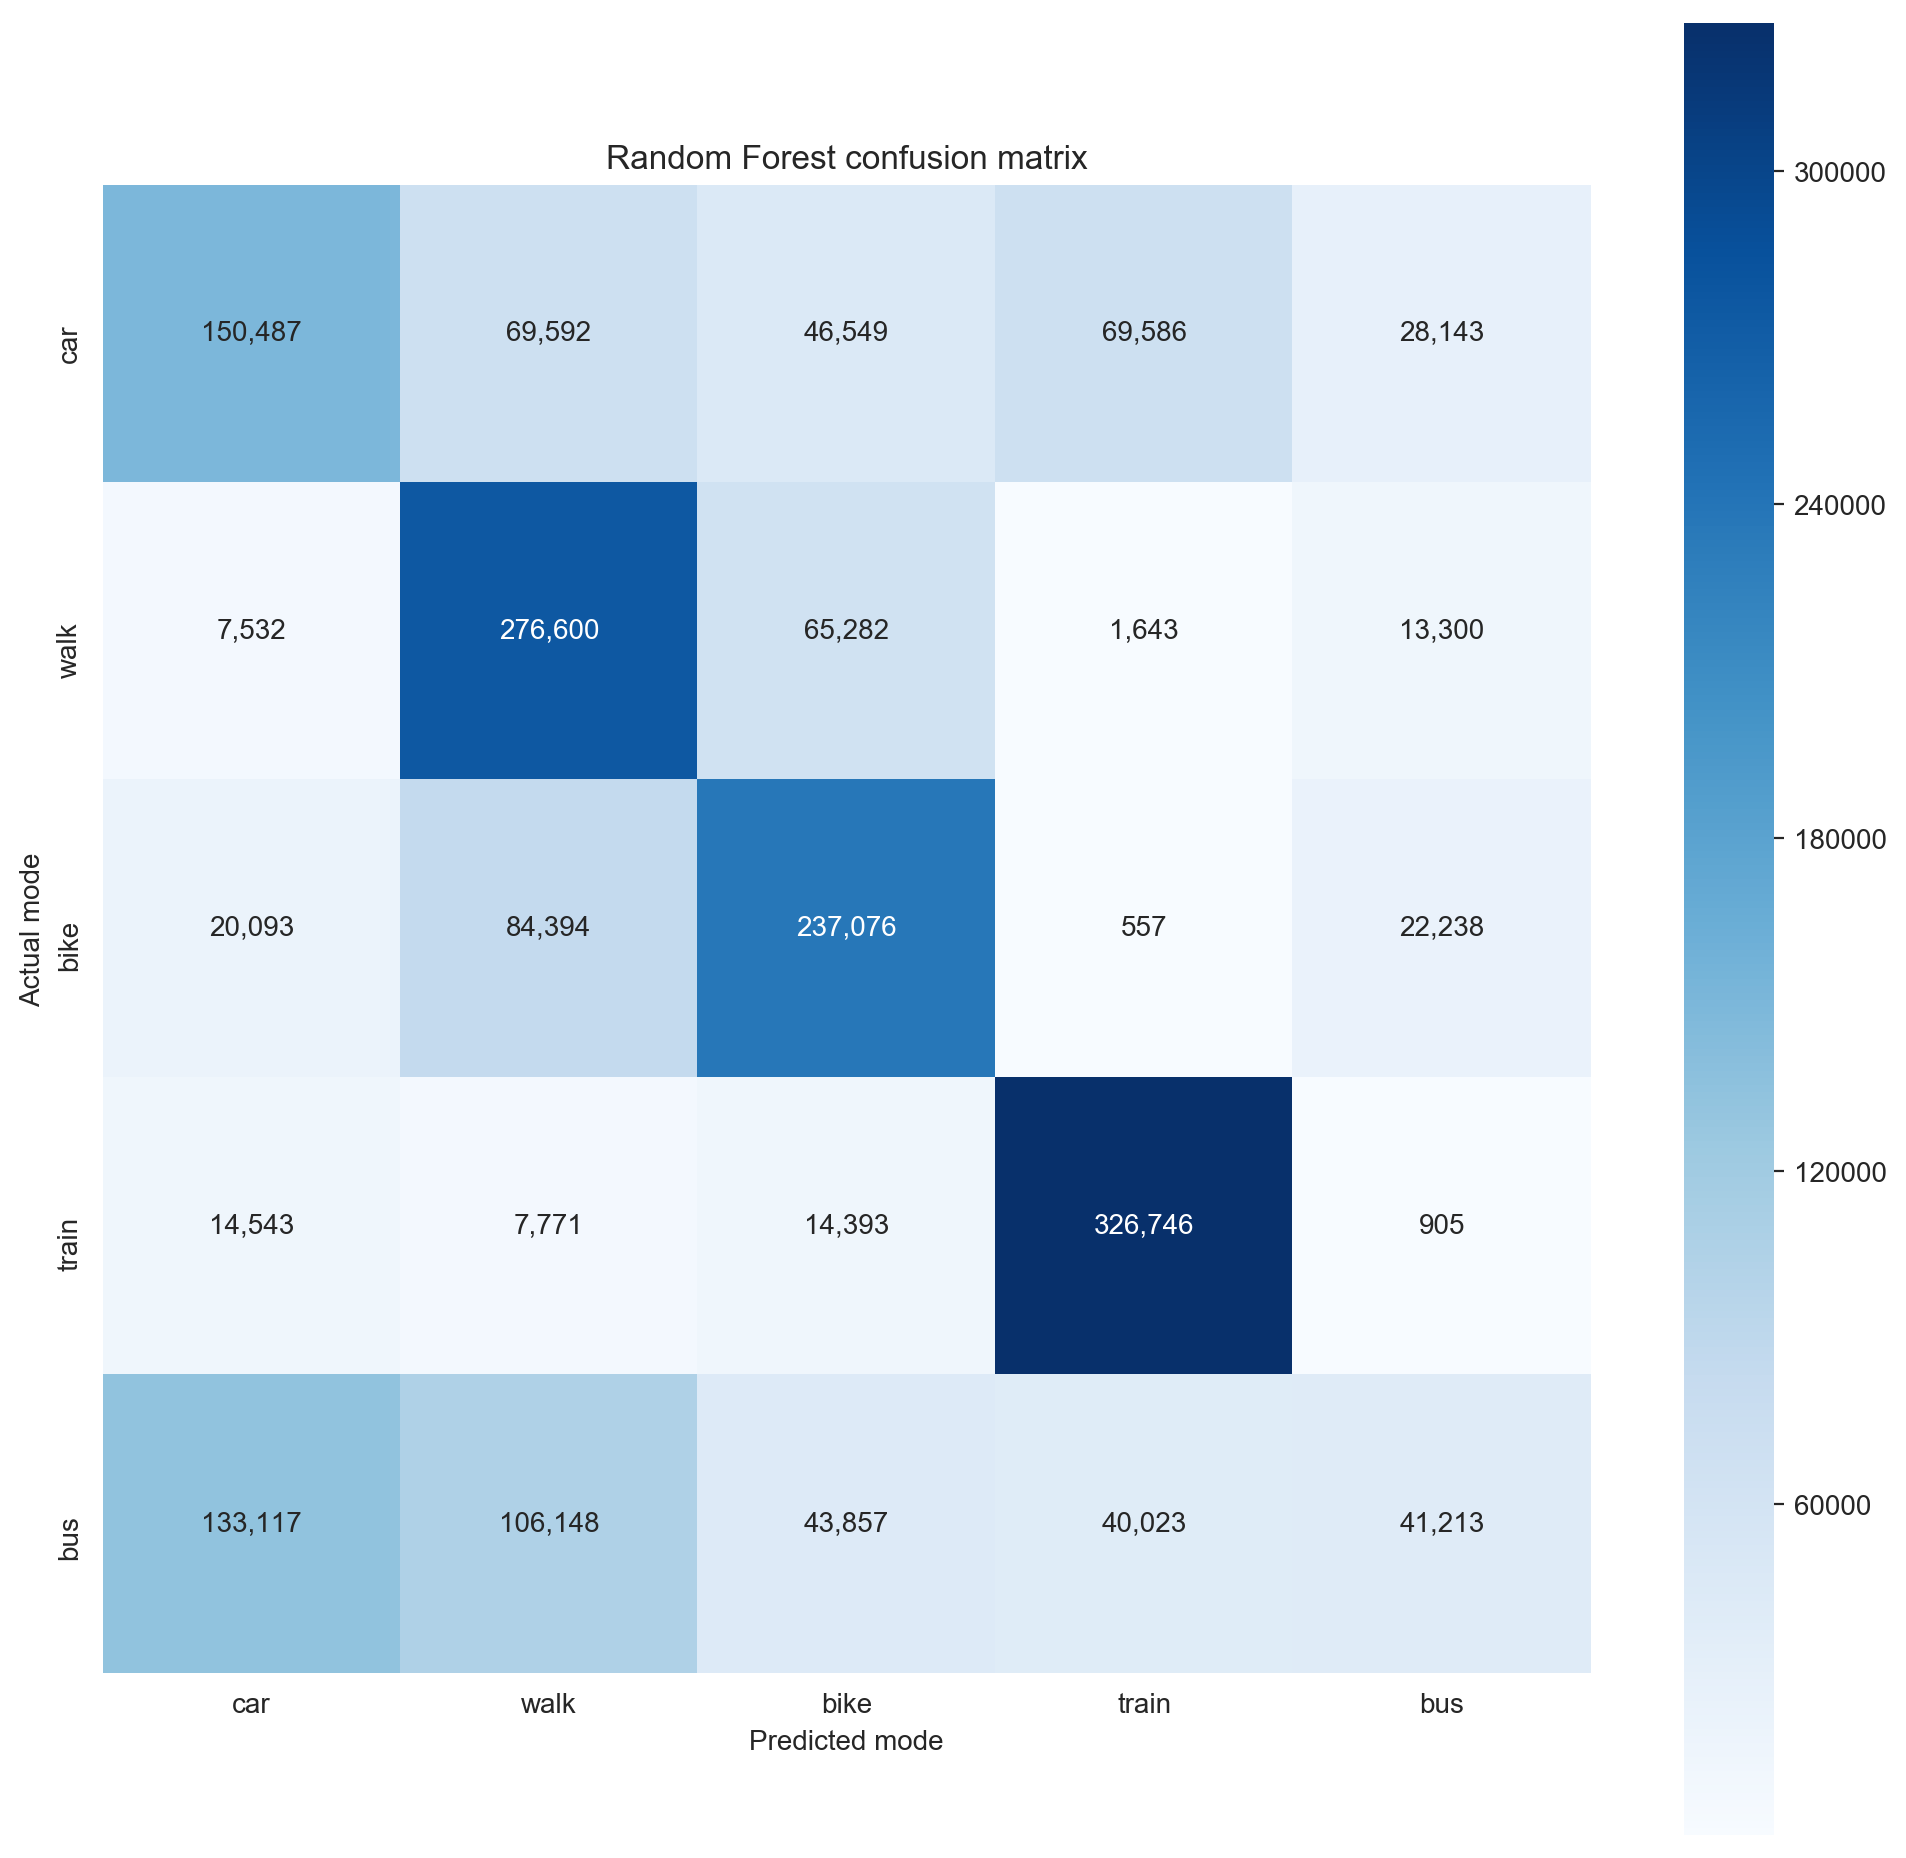

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=2,
                                                    stratify=y_resampled)
logit8 = LogisticRegression(n_jobs=-1, C = 0.95,solver = "newton-cg")
logit8.fit(X_train, y_train)
pickle.dump(logit8,  open("Logistic Rigrission_8","wb"))
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*logit8.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit8.score(X_test, y_test)))


plt.figure(figsize=(12,12),dpi=100)
rforest_confusion = confusion_matrix(y_test, logit8.predict(X_test),labels=["car", "walk" , "bike","train","bus"])
sns.heatmap(rforest_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt = ",d",
           xticklabels=["car", "walk" , "bike","train","bus"],
            yticklabels=["car", "walk" , "bike","train","bus"],)

plt.xlabel('Predicted mode')
plt.ylabel('Actual mode')
plt.title('Random Forest confusion matrix')
plt.savefig("Logist_regrission8.eps",format="eps")


In [150]:


# hyper_param_grid = {'max_depth': [i for i in range(3, 5)],
#                    'n_estimators': [10, 100]}

# rf = GridSearchCV(RandomForestClassifier(), hyper_param_grid, cv = 3, n_jobs = -1, verbose = 1)
# rf.fit(X_train, y_train)
# pp.pprint(rf.cv_results_)

In [151]:


# hyper_param_grid = {'n_estimators': [50,100,150]}

# rf = GridSearchCV(RandomForestClassifier(), hyper_param_grid, cv = 2, n_jobs = -1, verbose = 1)
# rf.fit(X_train, y_train)
# pp.pprint(rf.cv_results_)

The score for logistic regression is
Training:  99.96%
Test set:  85.89%


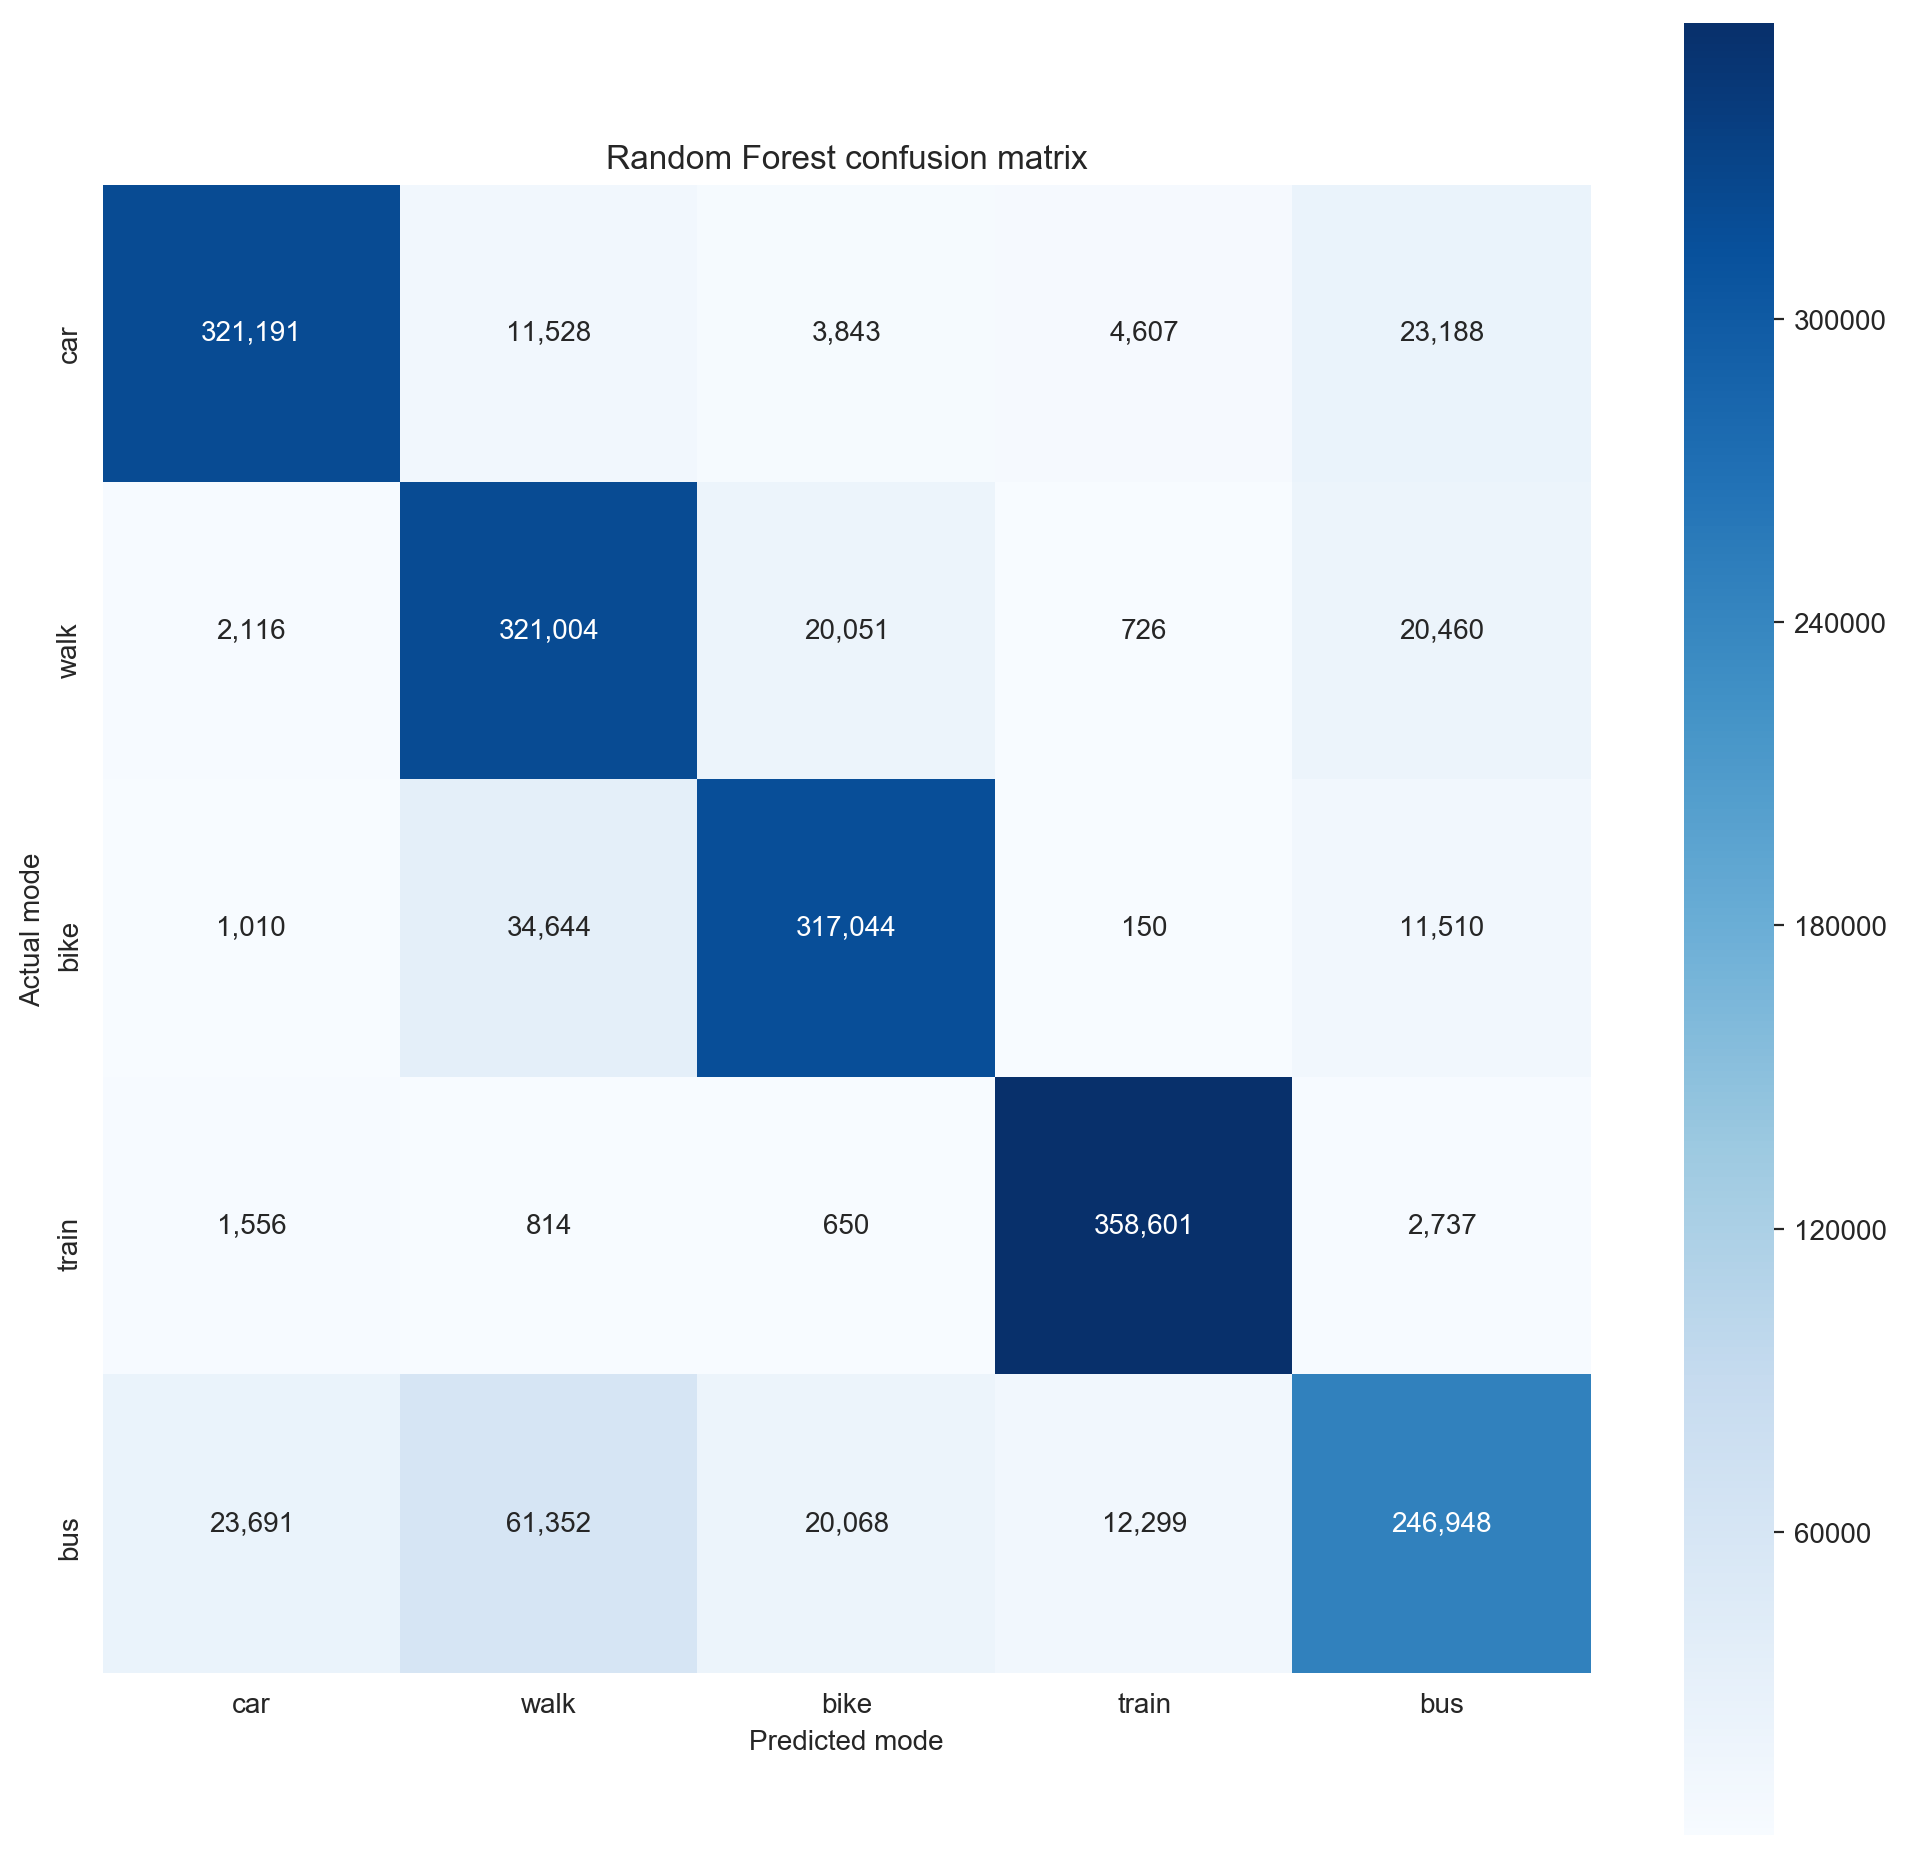

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=2,
                                                    stratify=y_resampled)
r_forest1  = RandomForestClassifier(max_depth=None,n_jobs=-1, n_estimators=100)
r_forest1.fit(X_train, y_train)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*r_forest1.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*r_forest1.score(X_test, y_test)))

pickle.dump(r_forest1,  open("RandomForest_1","wb"))
plt.figure(figsize=(12,12),dpi=100)
rforest_confusion = confusion_matrix(y_test, r_forest1.predict(X_test),labels=["car", "walk" , "bike","train","bus"])
sns.heatmap(rforest_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt = ",d",
           xticklabels=["car", "walk" , "bike","train","bus"],
            yticklabels=["car", "walk" , "bike","train","bus"],)

plt.xlabel('Predicted mode')
plt.ylabel('Actual mode')
plt.title('Random Forest confusion matrix')
plt.savefig("R_F1.eps",format="eps")

In [205]:
r_forest1.feature_importances_

array([0.05058319, 0.0201224 , 0.02111645, 0.05329031, 0.05470931,
       0.05536486, 0.04735231, 0.0586125 , 0.0198465 , 0.02133089,
       0.02055066, 0.02109167, 0.01950881, 0.01953033, 0.01906253,
       0.01869823, 0.01865797, 0.01860087, 0.04496485, 0.05158604,
       0.04636375, 0.04640673, 0.05102208, 0.02023913, 0.01956227,
       0.02009146, 0.0210599 , 0.02093763, 0.01867514, 0.0190655 ,
       0.01940497, 0.020283  , 0.02230776])

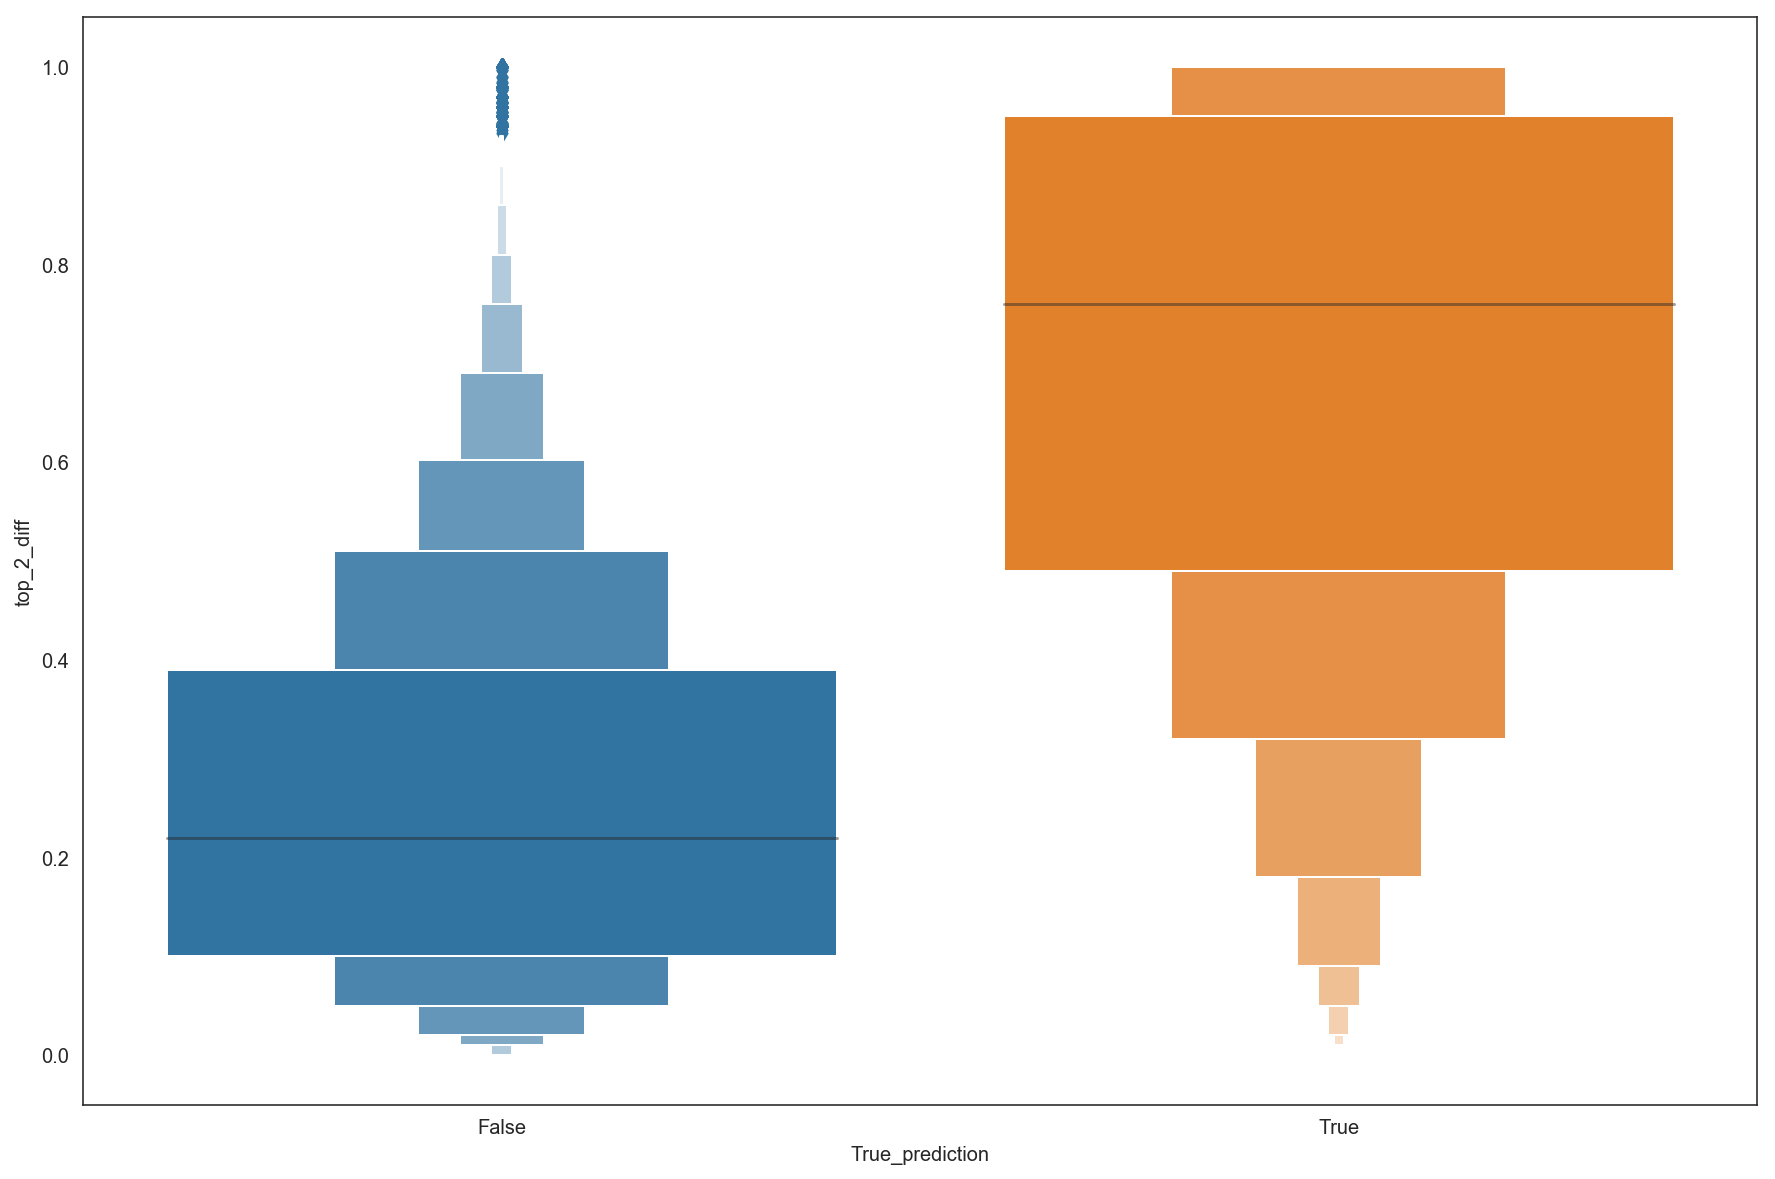

In [153]:
q_label = r_forest1.predict_proba(X_test).argsort()[:,::-1][:,:2]
q = r_forest1.predict_proba(X_test)
q.sort(axis= 1)
q = q[:,::-1][:,0]-q[:,::-1][:,1]
q_label_df = pd.DataFrame(q_label,dtype="str")
q_label_df["category"] = q_label_df[0]+"-"+q_label_df[1]
q_label_df["top_2_diff"] = q
q_label_df["prediction"] = r_forest1.predict(X_test)
q_label_df["actual"] = y_test
q_label_df["True_prediction"]= np.where(q_label_df["prediction"]==q_label_df["actual"],True, False)
q_label_df.sort_values("top_2_diff").to_csv("tableau2.csv")
plt.figure(figsize=(15,10))
sns.boxenplot(x= "True_prediction", y = "top_2_diff" ,data = q_label_df.loc[:,["True_prediction","top_2_diff"]])
plt.savefig("Diffrance of top 2 classes proba.eps",format = "eps")




The score for logistic regression is
Training:  57.49%
Test set:  57.54%


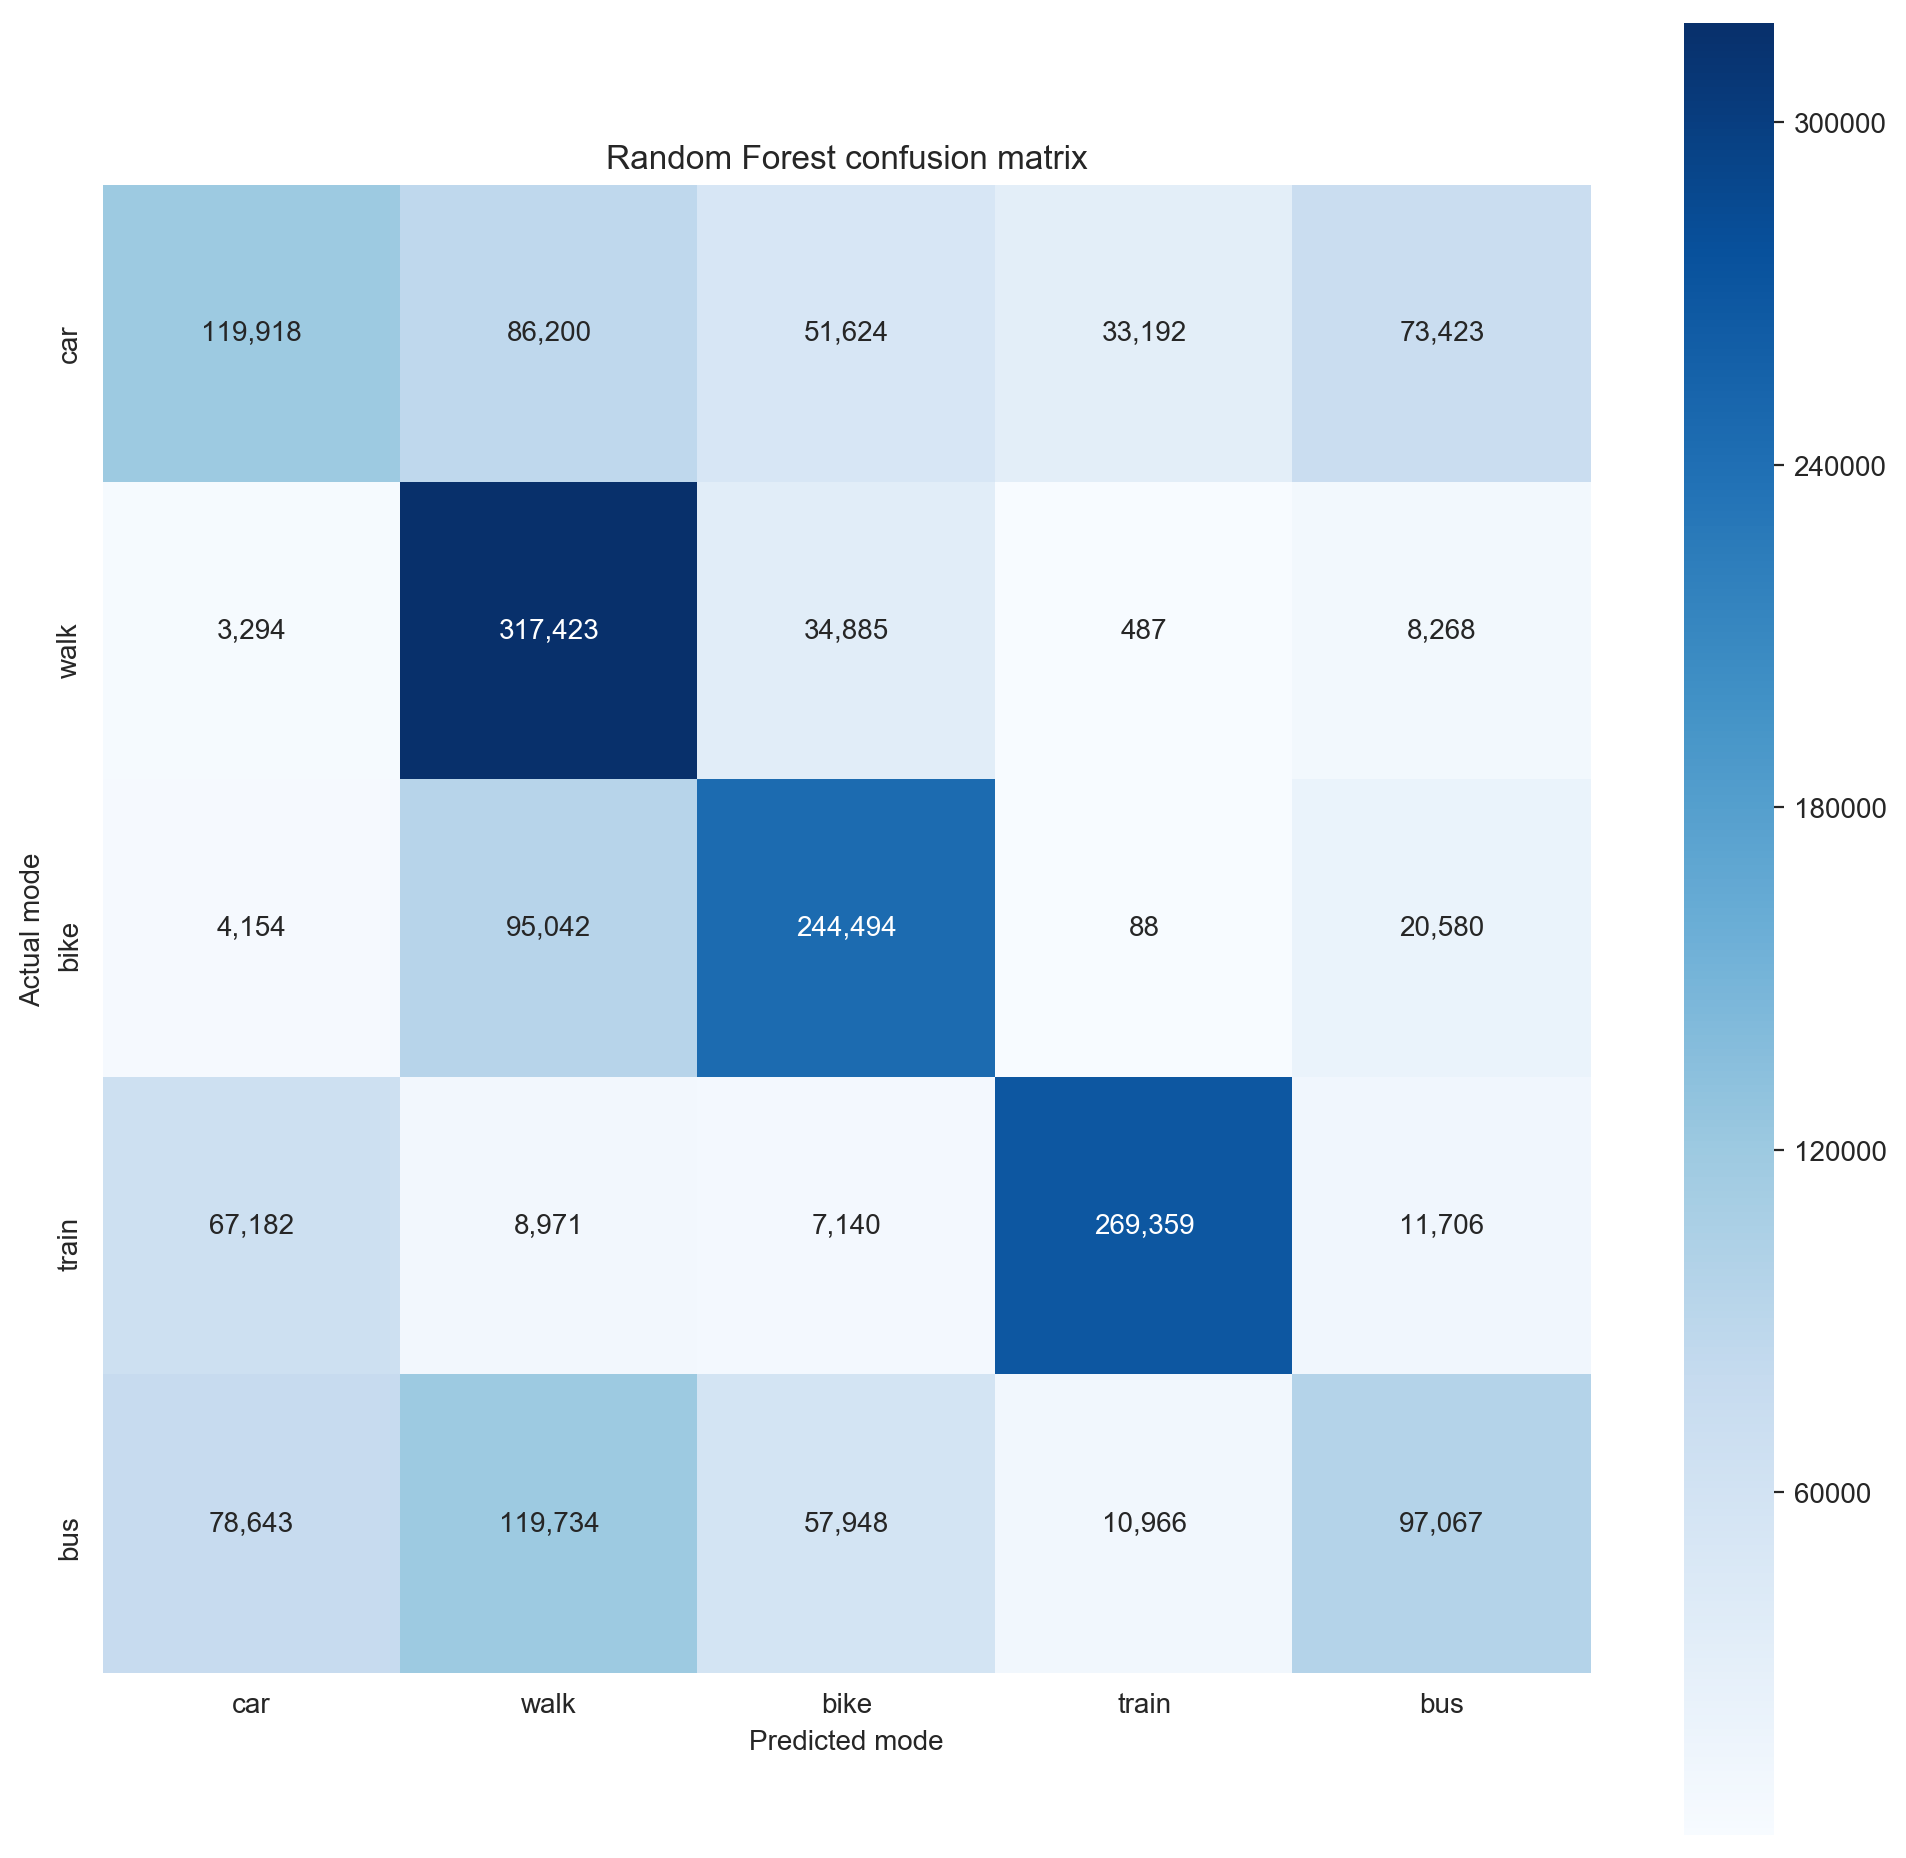

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=2,
                                                    stratify=y_resampled)
r_forest2  = ensemble.RandomForestClassifier(max_depth=(4),n_jobs=-1, n_estimators=100)
r_forest2.fit(X_train, y_train)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*r_forest2.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*r_forest2.score(X_test, y_test)))



pickle.dump(r_forest2,  open("RandomForest_2","wb"))
plt.figure(figsize=(12,12),dpi=100)
rforest_confusion = confusion_matrix(y_test, r_forest2.predict(X_test),labels=["car", "walk" , "bike","train","bus"])
sns.heatmap(rforest_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt = ",d",
           xticklabels=["car", "walk" , "bike","train","bus"],
            yticklabels=["car", "walk" , "bike","train","bus"],)

plt.xlabel('Predicted mode')
plt.ylabel('Actual mode')
plt.title('Random Forest confusion matrix')
plt.savefig("R_F2.eps",format="eps")

The score for logistic regression is
Training:  59.03%
Test set:  59.07%


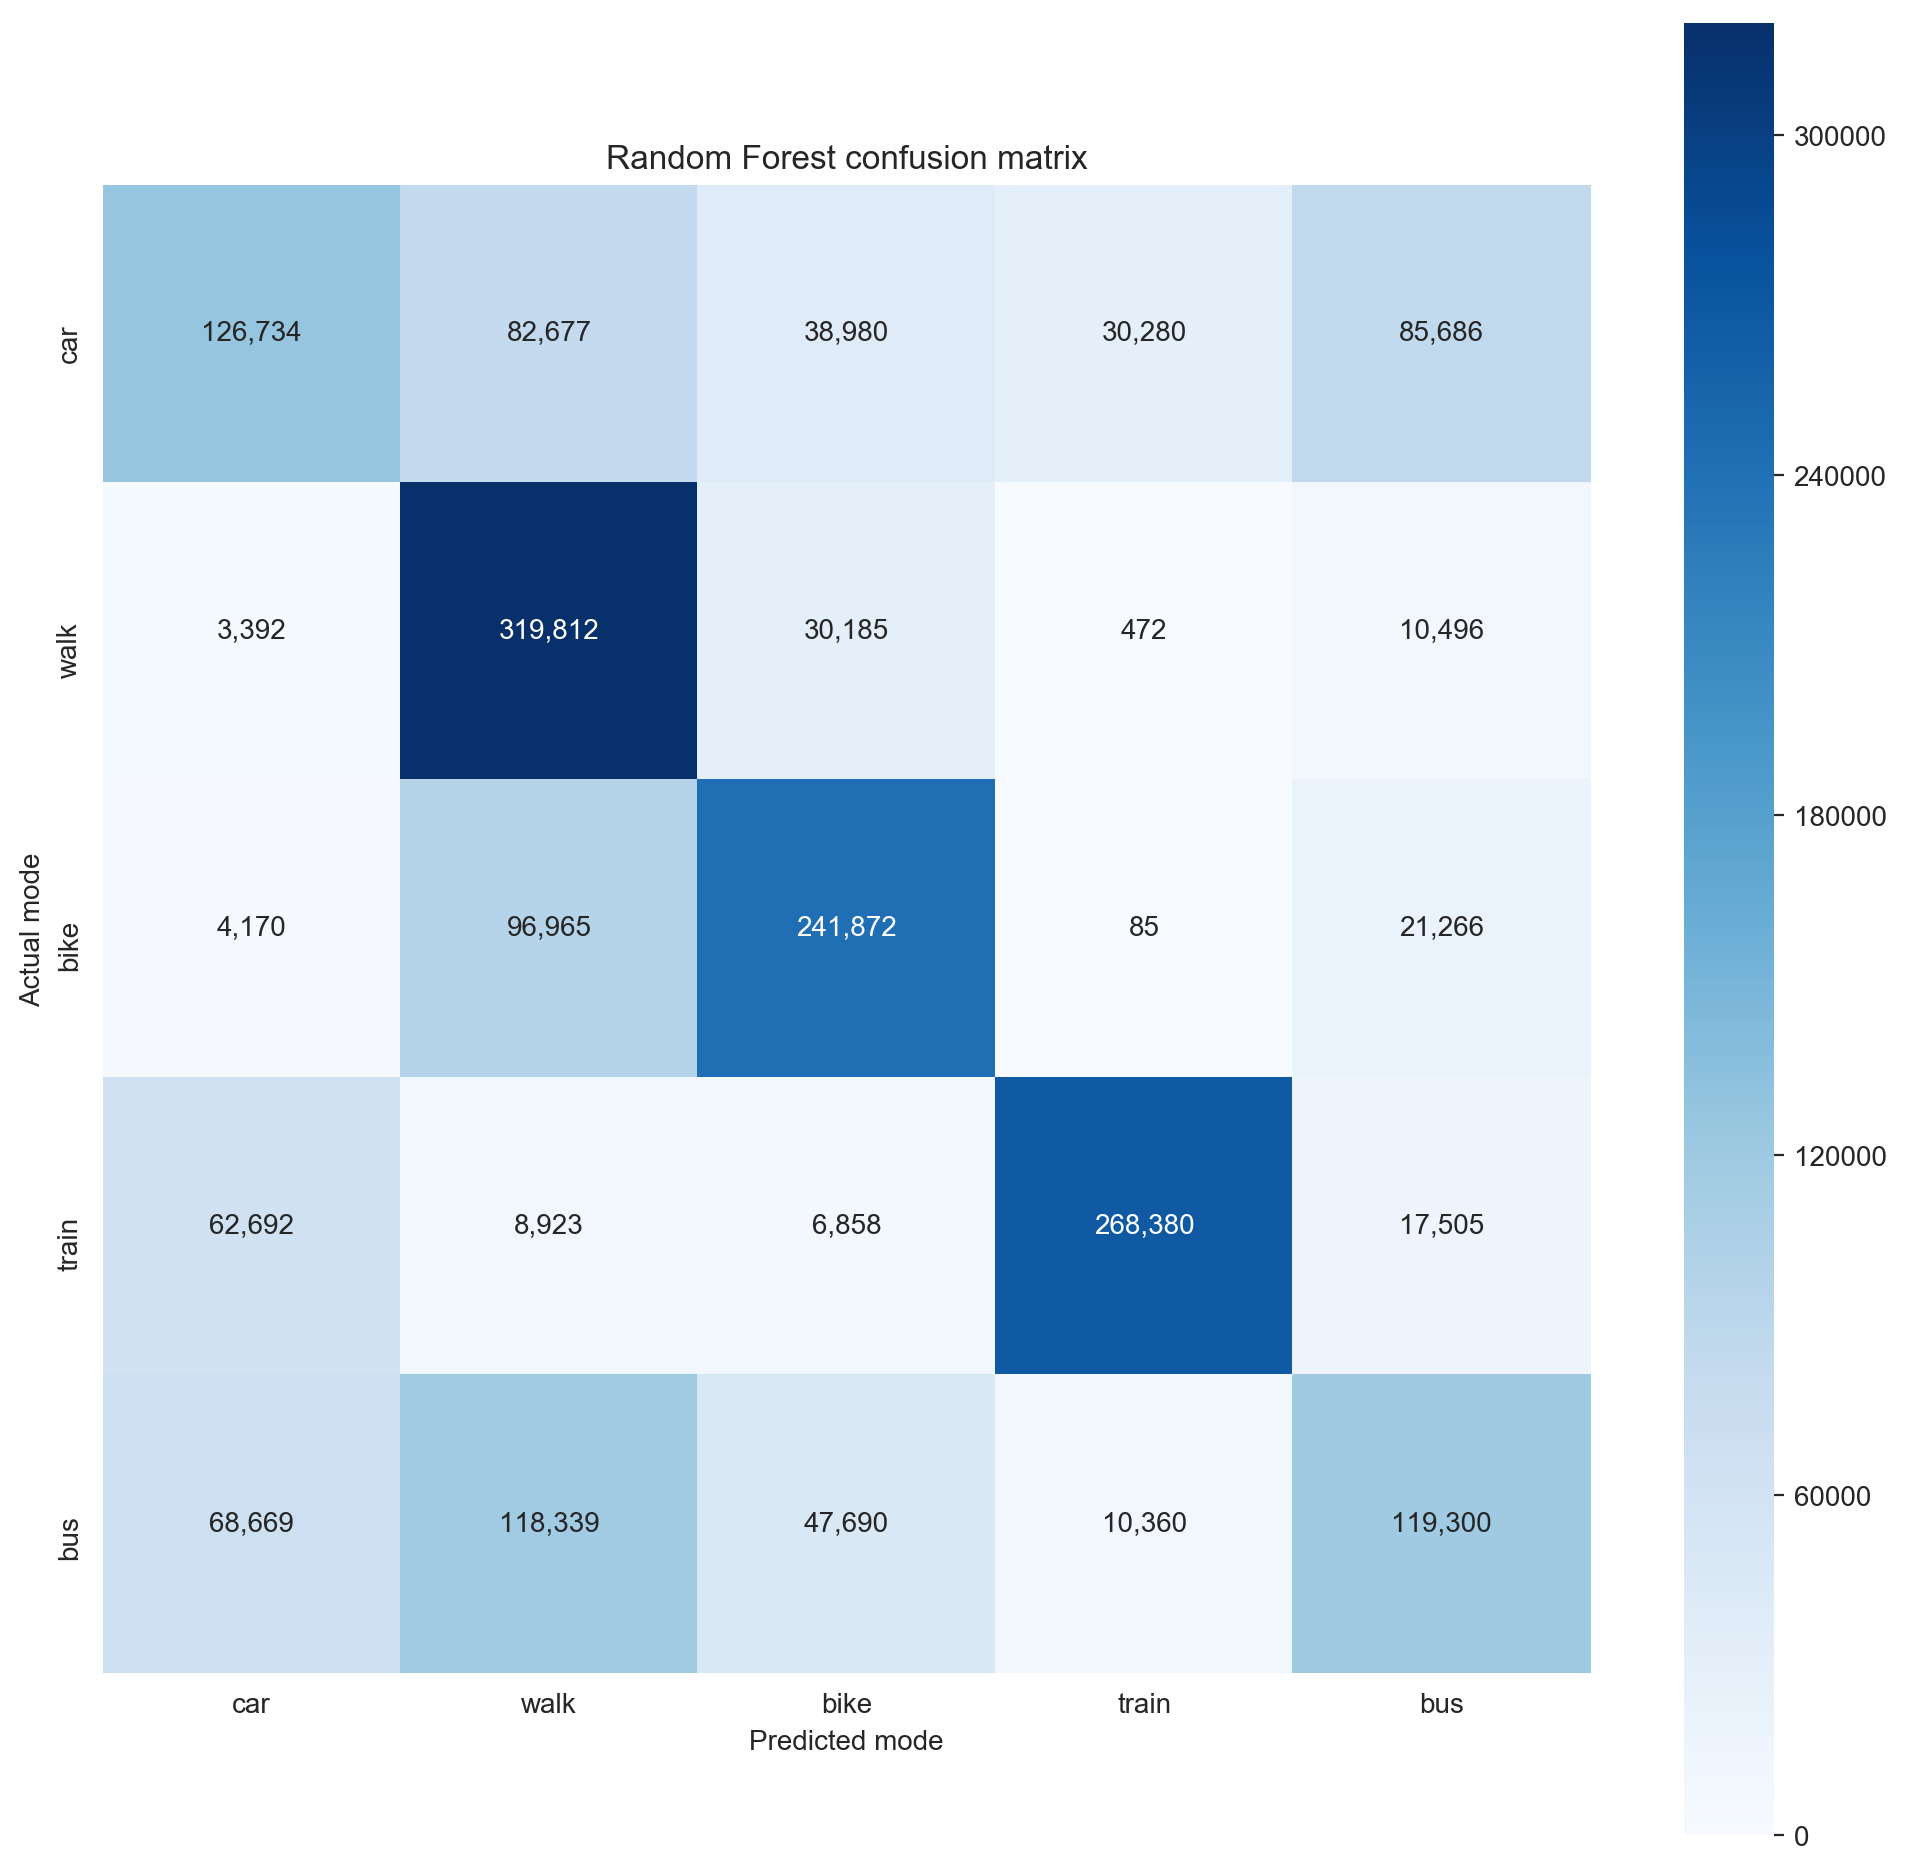

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=2,
                                                    stratify=y_resampled)
r_forest3  = ensemble.RandomForestClassifier(max_depth=(5),n_jobs=-1, n_estimators=100)
r_forest3.fit(X_train, y_train)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*r_forest3.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*r_forest3.score(X_test, y_test)))



pickle.dump(r_forest3,  open("RandomForest_3","wb"))
plt.figure(figsize=(12,12),dpi=100)
rforest_confusion = confusion_matrix(y_test, r_forest3.predict(X_test),labels=["car", "walk" , "bike","train","bus"])
sns.heatmap(rforest_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt = ",d",
           xticklabels=["car", "walk" , "bike","train","bus"],
            yticklabels=["car", "walk" , "bike","train","bus"],)

plt.xlabel('Predicted mode')
plt.ylabel('Actual mode')
plt.title('Random Forest confusion matrix')
plt.savefig("R_F3.eps",format="eps")

The score for logistic regression is
Training:  62.24%
Test set:  62.24%


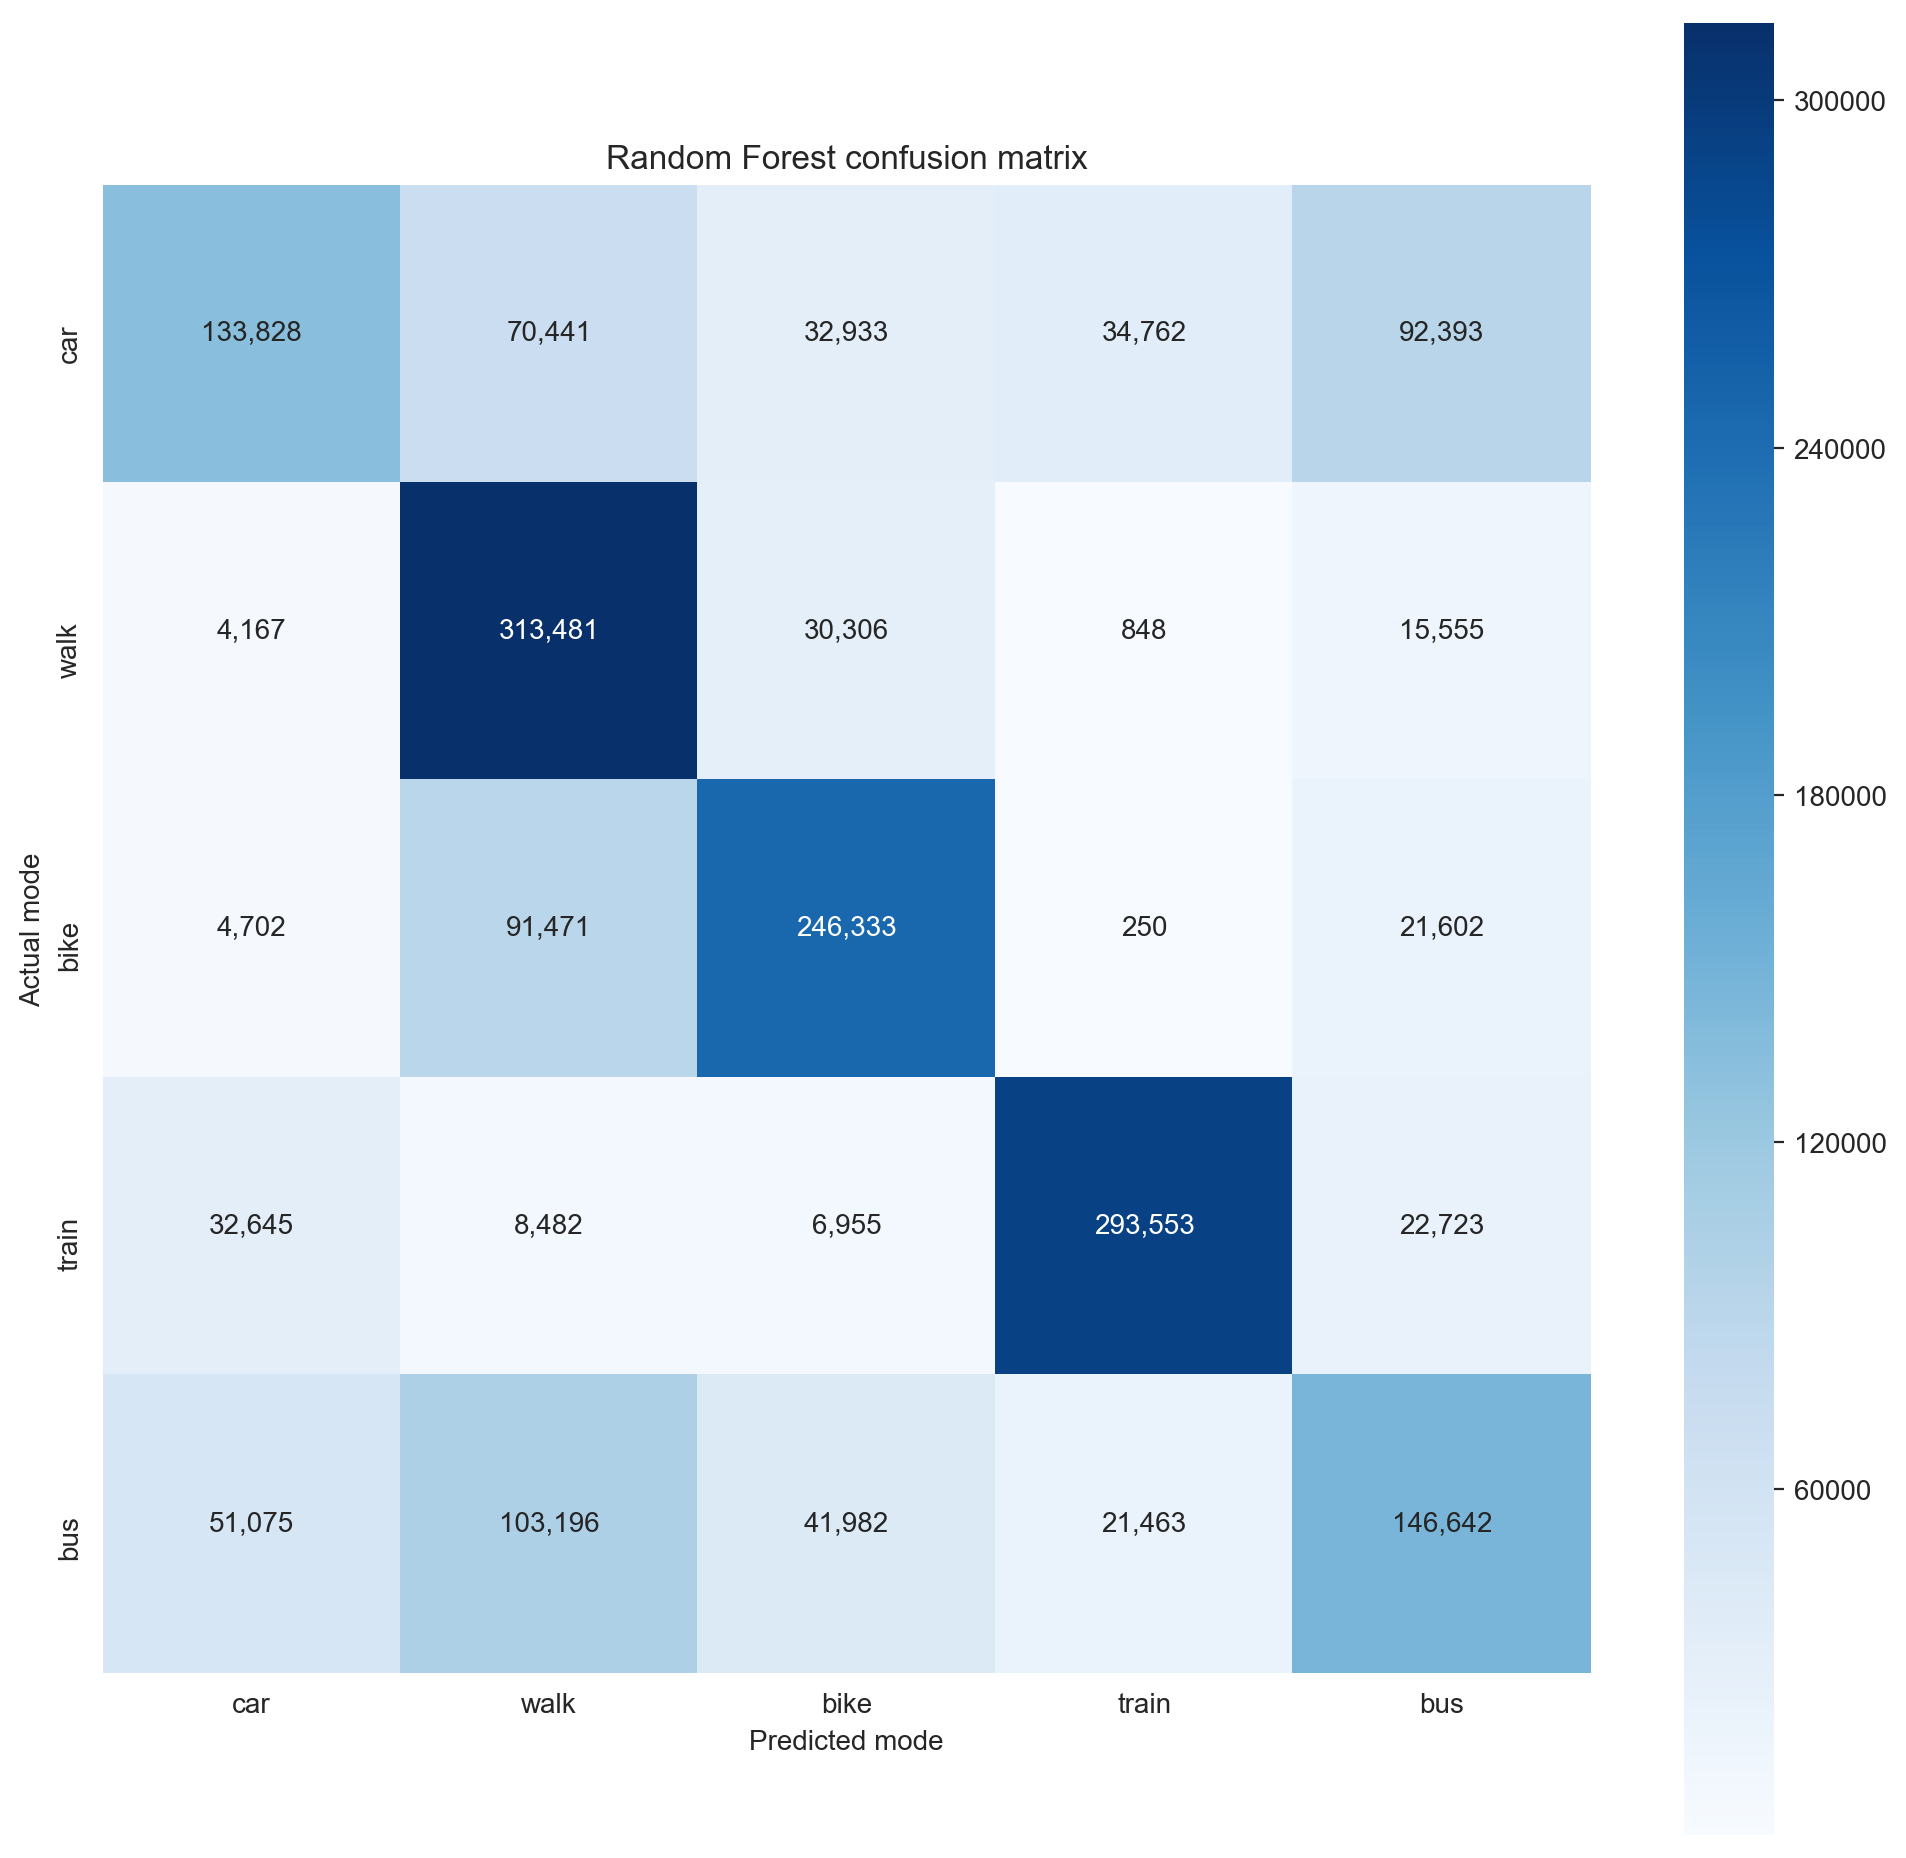

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=2,
                                                    stratify=y_resampled)
r_forest4  = ensemble.RandomForestClassifier(max_depth=(8),n_jobs=-1, n_estimators=100)
r_forest4.fit(X_train, y_train)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*r_forest4.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*r_forest4.score(X_test, y_test)))



pickle.dump(r_forest4,  open("RandomForest_4","wb"))
plt.figure(figsize=(12,12),dpi=100)
rforest_confusion = confusion_matrix(y_test, r_forest4.predict(X_test),labels=["car", "walk" , "bike","train","bus"])
sns.heatmap(rforest_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt = ",d",
           xticklabels=["car", "walk" , "bike","train","bus"],
            yticklabels=["car", "walk" , "bike","train","bus"],)

plt.xlabel('Predicted mode')
plt.ylabel('Actual mode')
plt.title('Random Forest confusion matrix')
plt.savefig("R_F4.eps",format="eps")

The score for logistic regression is
Training:  68.29%
Test set:  67.01%


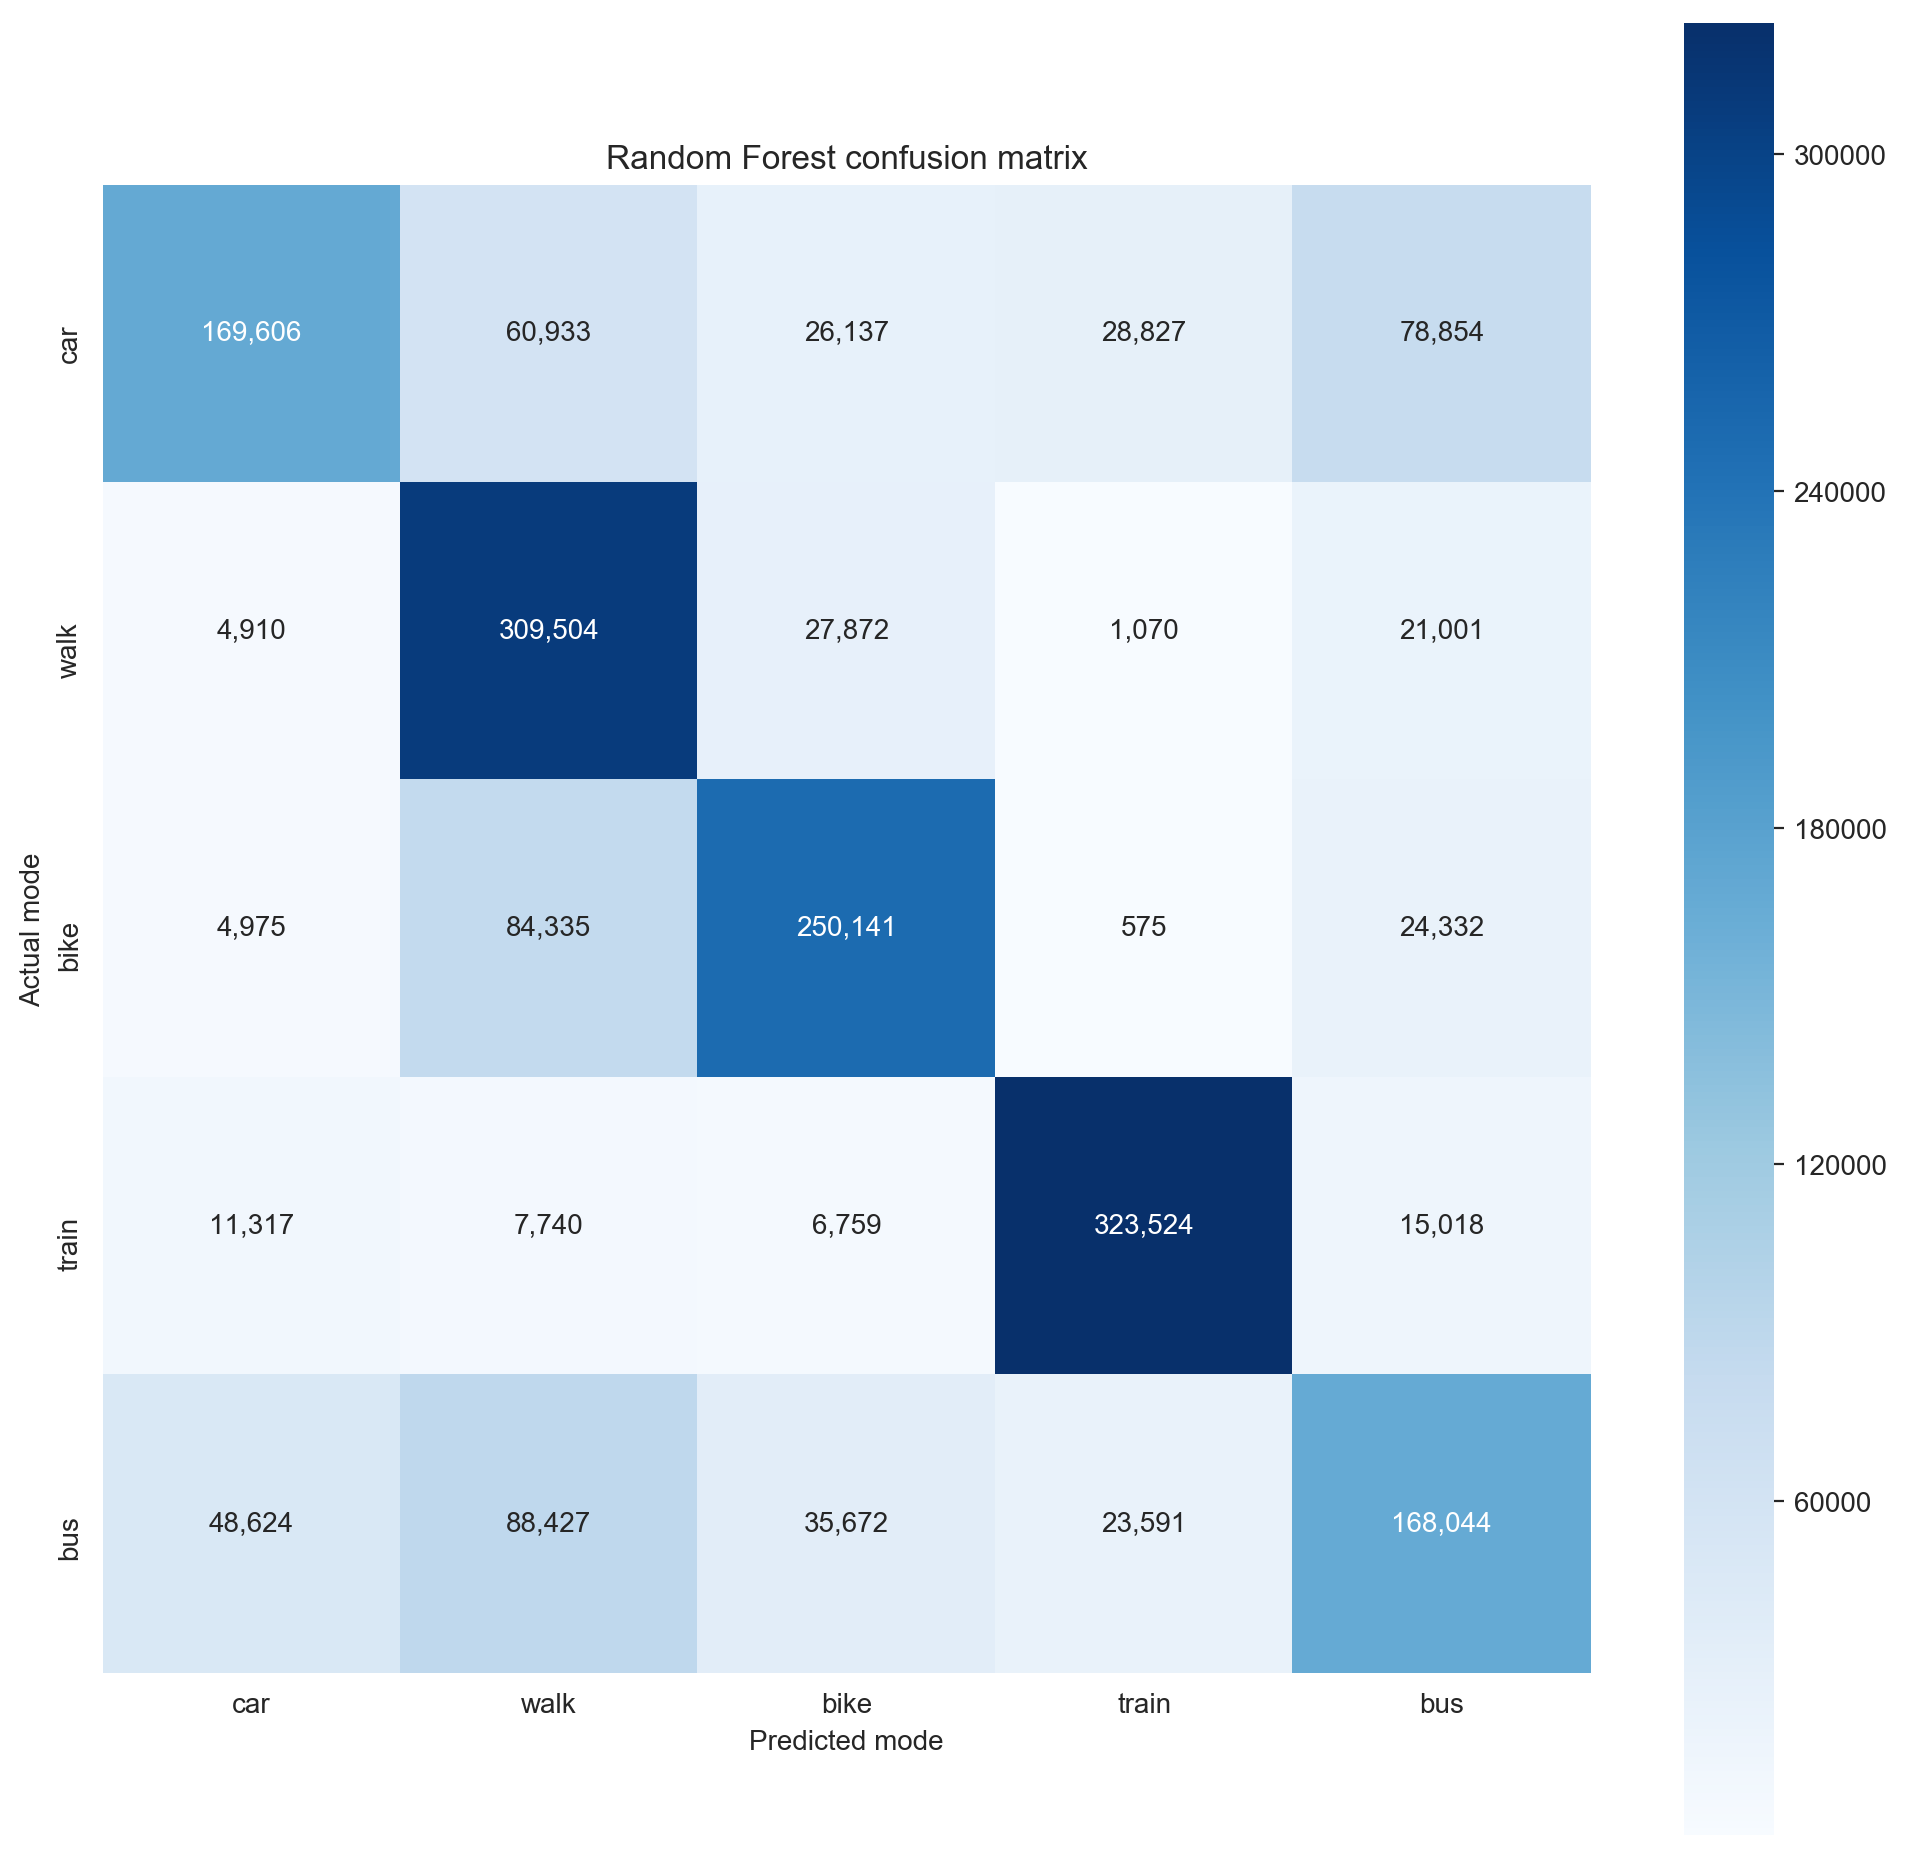

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=2,
                                                    stratify=y_resampled)
r_forest5  = ensemble.RandomForestClassifier(max_depth=(15),n_jobs=-1, n_estimators=100)
r_forest5.fit(X_train, y_train)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*r_forest5.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*r_forest5.score(X_test, y_test)))



pickle.dump(r_forest5,  open("RandomForest_5","wb"))
plt.figure(figsize=(12,12),dpi=100)
rforest_confusion = confusion_matrix(y_test, r_forest5.predict(X_test),labels=["car", "walk" , "bike","train","bus"])
sns.heatmap(rforest_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt = ",d",
           xticklabels=["car", "walk" , "bike","train","bus"],
            yticklabels=["car", "walk" , "bike","train","bus"],)

plt.xlabel('Predicted mode')
plt.ylabel('Actual mode')
plt.title('Random Forest confusion matrix')
plt.savefig("R_F5.eps",format="eps")

The score for logistic regression is
Training:  99.11%
Test set:  86.16%


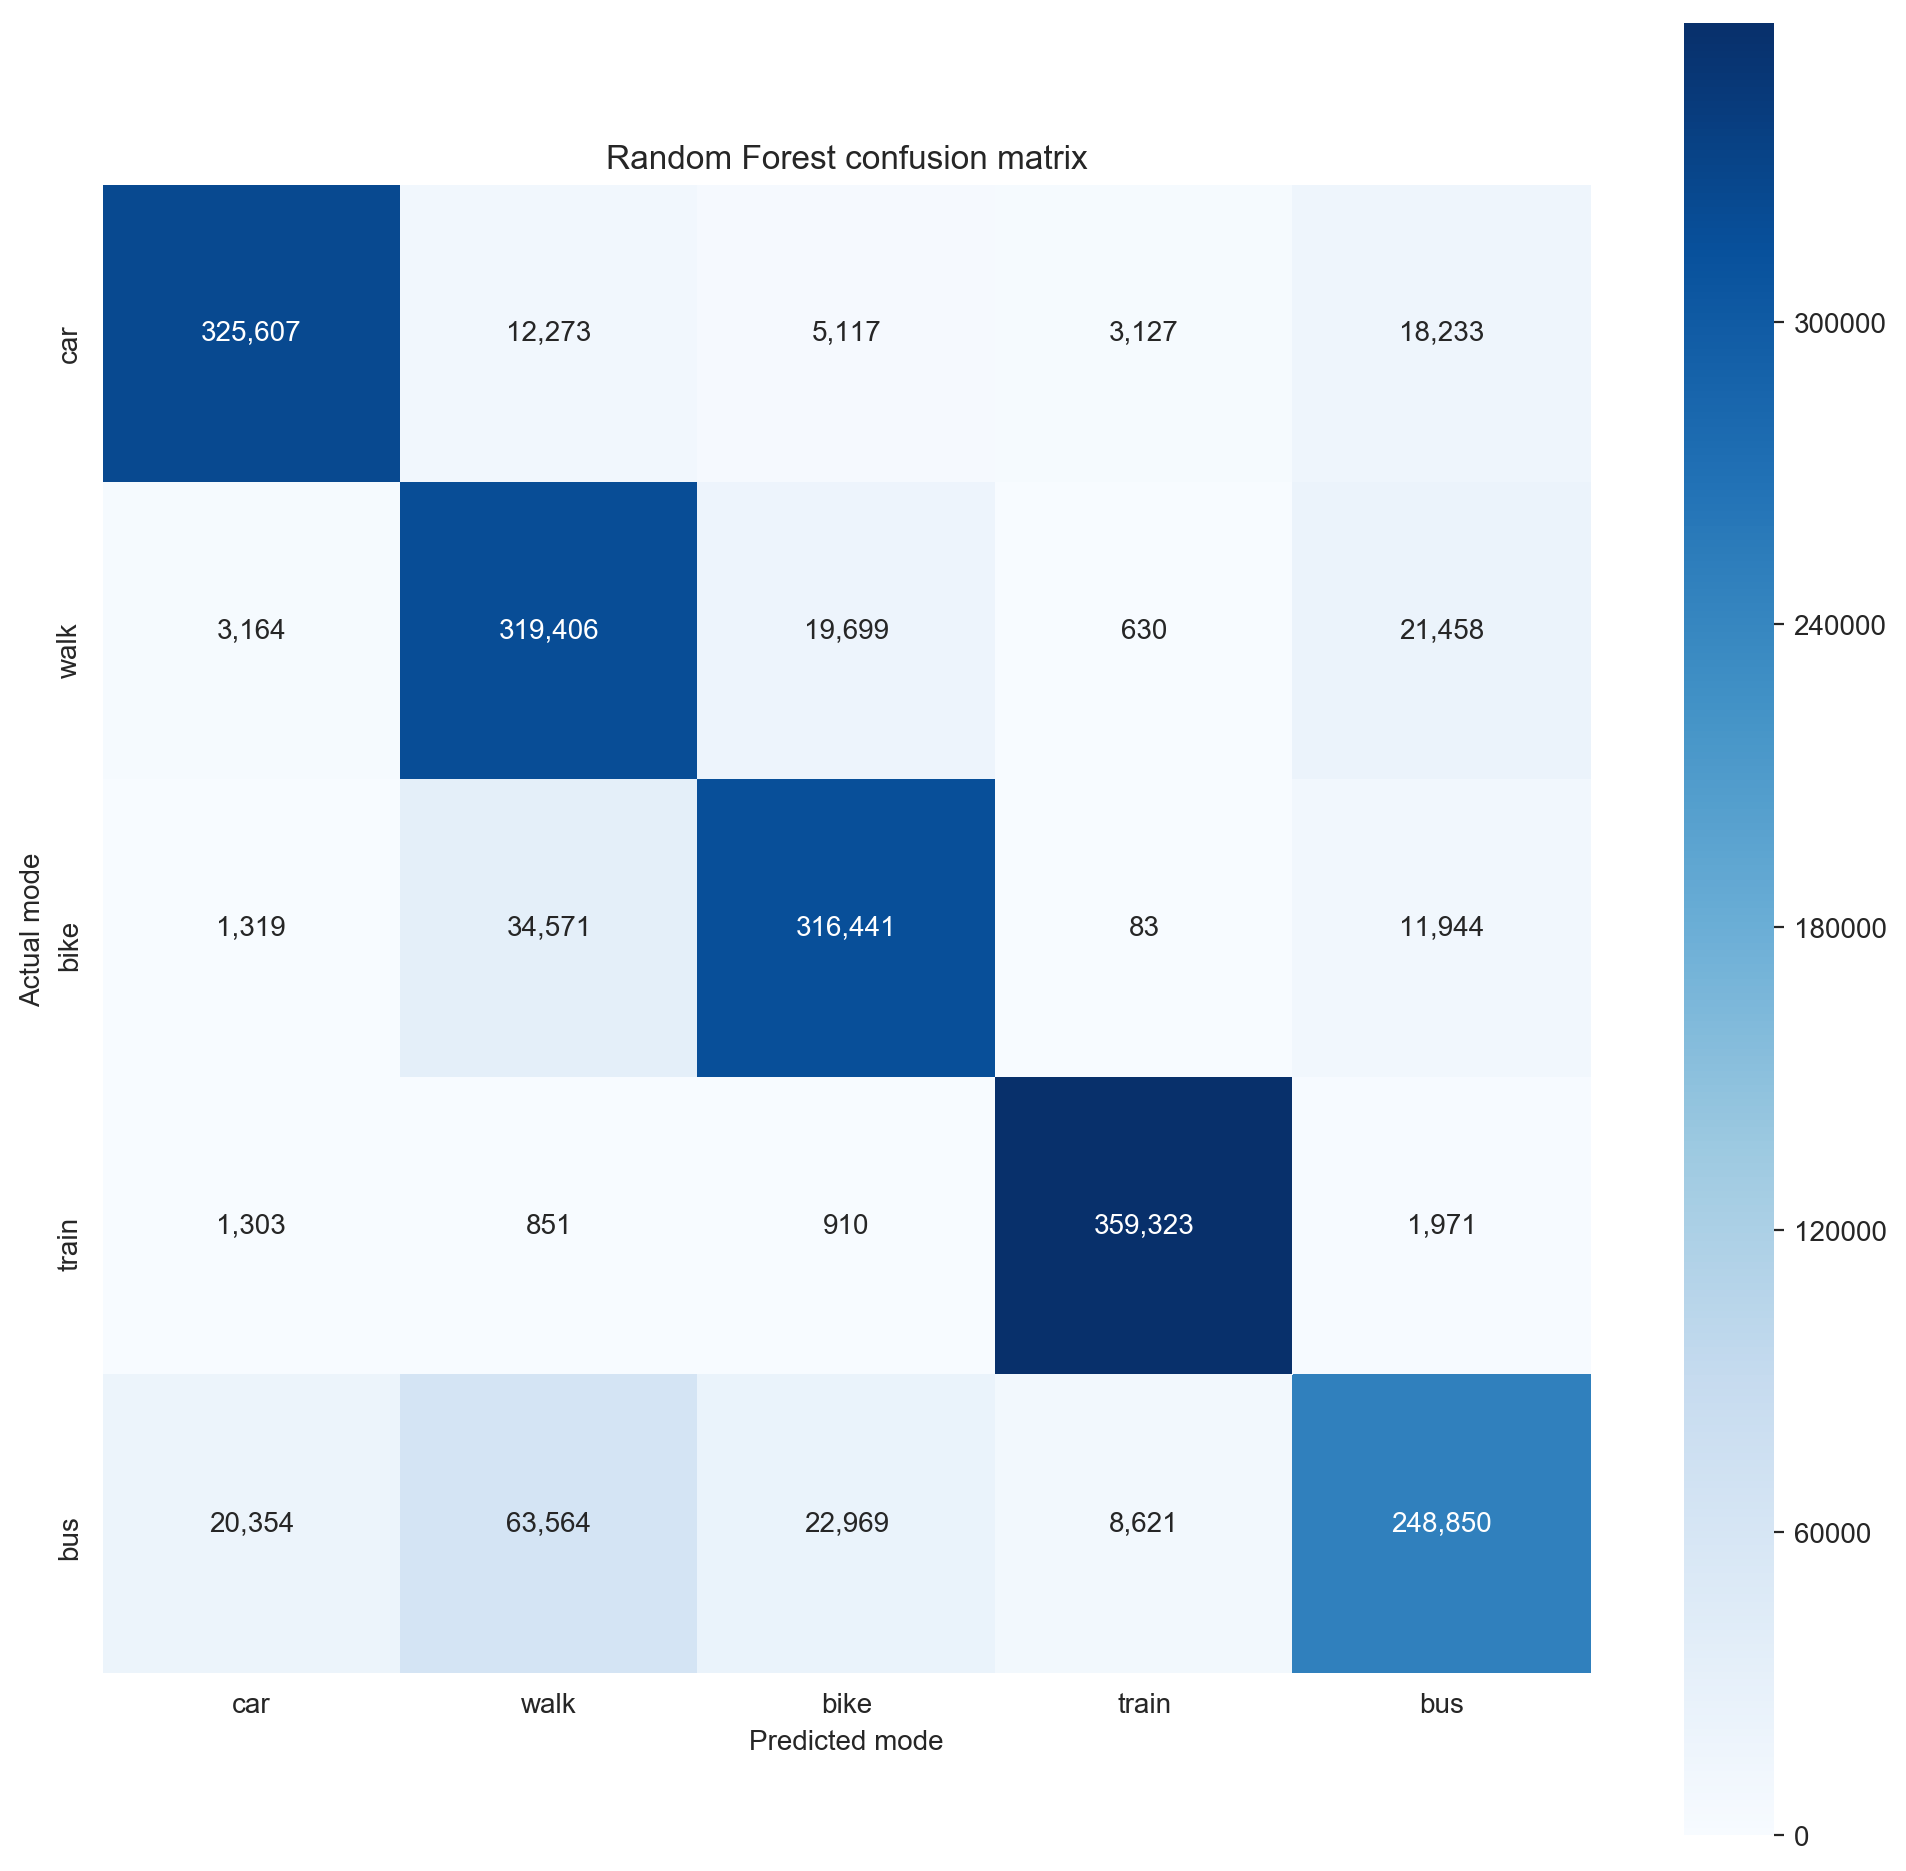

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=2,
                                                    stratify=y_resampled)
r_forest6  = ensemble.RandomForestClassifier(max_depth=(35),n_jobs=-1, n_estimators=100)
r_forest6.fit(X_train, y_train)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*r_forest6.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*r_forest6.score(X_test, y_test)))



pickle.dump(r_forest6,  open("RandomForest_6","wb"))
plt.figure(figsize=(12,12),dpi=100)
rforest_confusion = confusion_matrix(y_test, r_forest6.predict(X_test),labels=["car", "walk" , "bike","train","bus"])
sns.heatmap(rforest_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt = ",d",
           xticklabels=["car", "walk" , "bike","train","bus"],
            yticklabels=["car", "walk" , "bike","train","bus"],)

plt.xlabel('Predicted mode')
plt.ylabel('Actual mode')
plt.title('Random Forest confusion matrix')
plt.savefig("R_F6.eps",format="eps")

In [159]:
model3 = pd.concat([pd.DataFrame(X_resampled),pd.DataFrame(y_resampled,columns= ["transportation_mode"])],axis = 1)

In [161]:
modes2 = {"walk":"walk","bus":"drop","train":"drop","car":"car","bike":"bike"}

    
model3["transportation_mode2"] = model3.apply(lambda x : modes2[x["transportation_mode"]],axis=1)

model3 = model3[model3["transportation_mode2"]!="drop"]
model3.drop(columns="transportation_mode",inplace=True)

The score for logistic regression is
Training:  99.98%
Test set:  91.50%


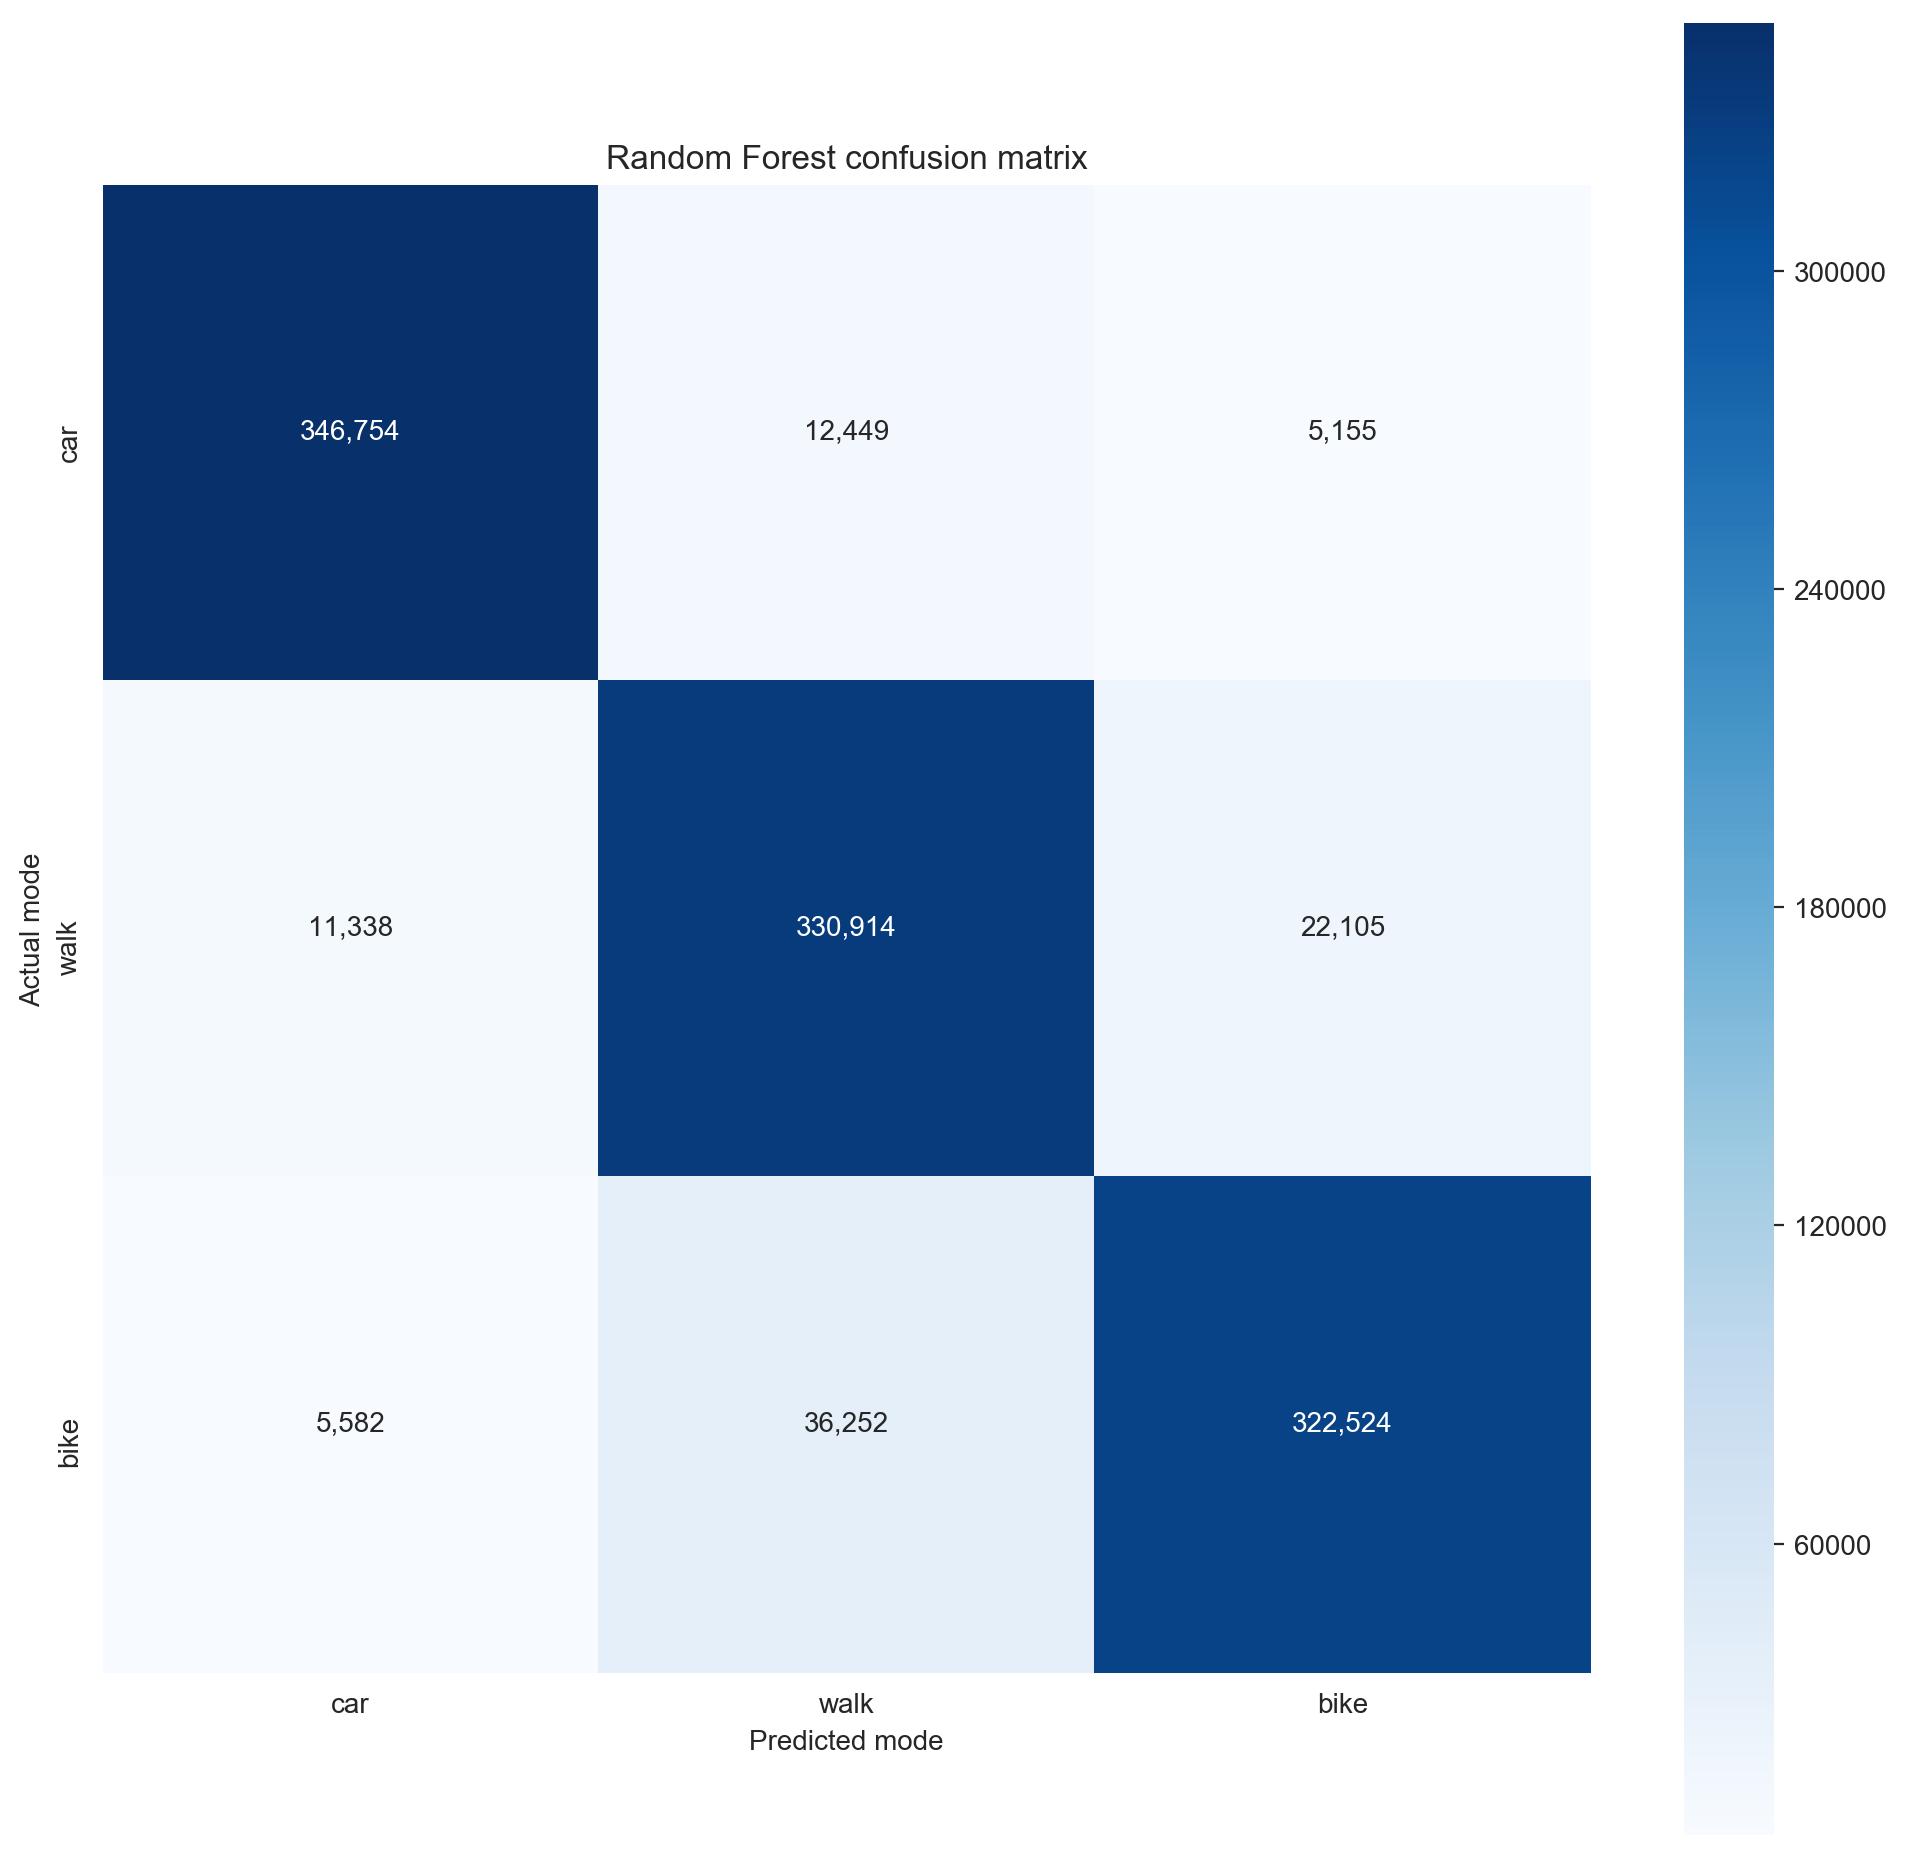

In [162]:
X = model3.iloc[:,:-1]
y = model3.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2,
                                                    stratify=y)
r_forest7  = ensemble.RandomForestClassifier(max_depth=None,n_jobs=-1, n_estimators=100)
r_forest7.fit(X_train, y_train)

print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*r_forest7.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*r_forest7.score(X_test, y_test)))



pickle.dump(r_forest7,  open("RandomForest_7","wb"))
plt.figure(figsize=(12,12),dpi=100)
rforest_confusion = confusion_matrix(y_test, r_forest7.predict(X_test),labels=["car", "walk" , "bike"])
sns.heatmap(rforest_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt = ",d",
           xticklabels=["car", "walk" , "bike"],
            yticklabels=["car", "walk" , "bike"])

plt.xlabel('Predicted mode')
plt.ylabel('Actual mode')
plt.title('Random Forest confusion matrix')
plt.savefig("R_F7.eps",format="eps")


Copy data into CSV for Tableau

In [ ]:
pd.read_pickle("~/Documents/Project 3/prject_3_labeled_data_v1.2.pickle").to_csv("~/Documents/Project 3/prject_3_labeled_data_v1.2.csv")